<div style="padding:15px 20px 20px 20px;border-left:3px solid #87CEFA;background-color:#f0fbff;border-radius: 20px;color:#424242;">

# **Results Notebook Description**

## Table of Contents
- **1. Setup**
    - 1.1) Local Setup
    - 1.2) Downloading the Data

- **2. Exploratory Data Analysis (EDA)**
    - **2.1. Channel Dataset**
        - 2.1.A) General Statistics of the Channel Dataset 
        - 2.1.B) Example of Channel Data: The Music Category

    - **2.2. Time Series Dataset**
        - 2.2.A) Example of Time Series Data: The evolution of some famous channels
        - 2.2.B) Various distributions of the time series data
        - 2.2.C) Comparison of the distributions across different categories

    - **2.3. Video Metadata Dataset Analysis**
        - 2.3.A) Example of Video Metadata Statistics for the Music Category
        - 2.3.B) Comparison of duration distribution for the Music and Entertainment categories
        - 2.3.C) Comparison of estimated monetization and viewer engagement distribution for the Music and Entertainment categories

    - **2.4. Comment Dataset Analysis**
        - Histograms of number of videos and authors per number of comments

- **3. Collaboration Analysis**
    - **3.1 Processing**
    - **3.2. Collaboration Detection: Does Collaboration Have an Overall Beneficial Effect in Terms of Viewership, Number of Likes and Dislikes?**
    - **3.3. Analysis of Collaboration Rates and Channel Popularity?**

</div>

# 1. Setup

## 1.1) Local Setup

In [1]:
# Install the dependencies
# !pip install -r requirements.txt

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Let's start with the necessary imports, we will use $\LaTeX$ for the plots if it is available. 

</div>

In [9]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import src.utils.data_utils as data_utils
import src.utils.collab_utils as collab_utils

# Check if LaTeX is available, if not we don't import the plot_config module
latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False 

# Import the plot_config module if LaTeX is available
if latex_available:
    import src.utils.plot_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ROOT_PATH = os.getcwd()
DATA_PATH = '/Volumes/Crucial X6 1/YouNiverse' #os.path.join(ROOT_PATH, 'data') TODO: Change this to the correct path
TIME_SERIES_PATH = os.path.join(DATA_PATH, 'time_series')
CHANNELS_PATH = os.path.join(DATA_PATH, 'channels')
VIDEO_METADATA_PATH = os.path.join(DATA_PATH, 'video_metadata')

## 1.2) Downloading the Data

In [4]:
# Download the datasets (ordered by size), comment out the ones you don't need 
datasets = [
    # ("https://zenodo.org/records/4650046/files/_raw_df_channels.tsv.gz?download=1", "channels.tsv.gz"), # 6.0 MB
    # ("https://zenodo.org/records/4650046/files/_raw_df_timeseries.tsv.gz?download=1", "time_series.tsv.gz" ), # 571.1 MB
    # ("https://zenodo.org/records/4650046/files/num_comments.tsv.gz?download=1", "num_comments.tsv.gz"), # 754.6 MB
    # ("https://zenodo.org/records/4650046/files/num_comments_authors.tsv.gz?download=1", "num_comments_authors.tsv.gz"), # 1.4 GB
    # ("https://zenodo.org/records/4650046/files/yt_metadata_en.jsonl.gz?download=1", "yt_metadata.jsonl.gz"), # 13.6 GB
    # ("https://zenodo.org/records/4650046/files/youtube_comments.tsv.gz?download=1", "youtube_comments.tsv.gz") # 77.2 GB
]

data_utils.get_data(datasets)

# 2. Exploratory Data Analysis (EDA)

## 2.1 Channel Dataset Analysis

### 2.1.A) General Statistics of the Channel Dataset

Here, we start by loading the channel dataset. First, we cast the columns to the appropriate data types. Then, we plot the distribution of the number of channels, subscribers, and videos by category at the crawling time using pie charts. In a last step, we save the channels in separate files for each category.

**Observations:**
- **Number of channels and subscribers**: The `Music` and `Entertainment` categories have the highest number of channels and subscribers.
- **Number of videos**: The number of videos is dominated by the `News & Politics` category, this is due to the high number of news channels that publish multiple videos daily. Still, the `Music` category and `Entertainment` are respectively the second and fourth categories with the highest number of videos.

In [26]:
df_channels = pd.read_csv(f"{DATA_PATH}/channels.tsv.gz", sep="\t", compression="gzip")
df_channels = data_utils.cast_df(df_channels, type='channel')
df_channels.head(3)

category_cc  join_date                   channel  \
0  Film and Animation 2017-05-21  UCBJuEqXfXTdcPSbGO9qqn1g   
1       Entertainment 2011-12-13  UCkNW9Q1VR_aeZ6uht83jJVQ   
2               Music 2008-03-17  UCXhkGgooXHDNwgJXmoTSN7g   

                   name_cc  subscribers_cc  videos_cc  subscriber_rank_sb  
0             MagnusNation           65100         28            231223.0  
1  Mago Dario Animazion...           60200         48            238538.0  
2             Mago Merlino           14800        838            707828.0

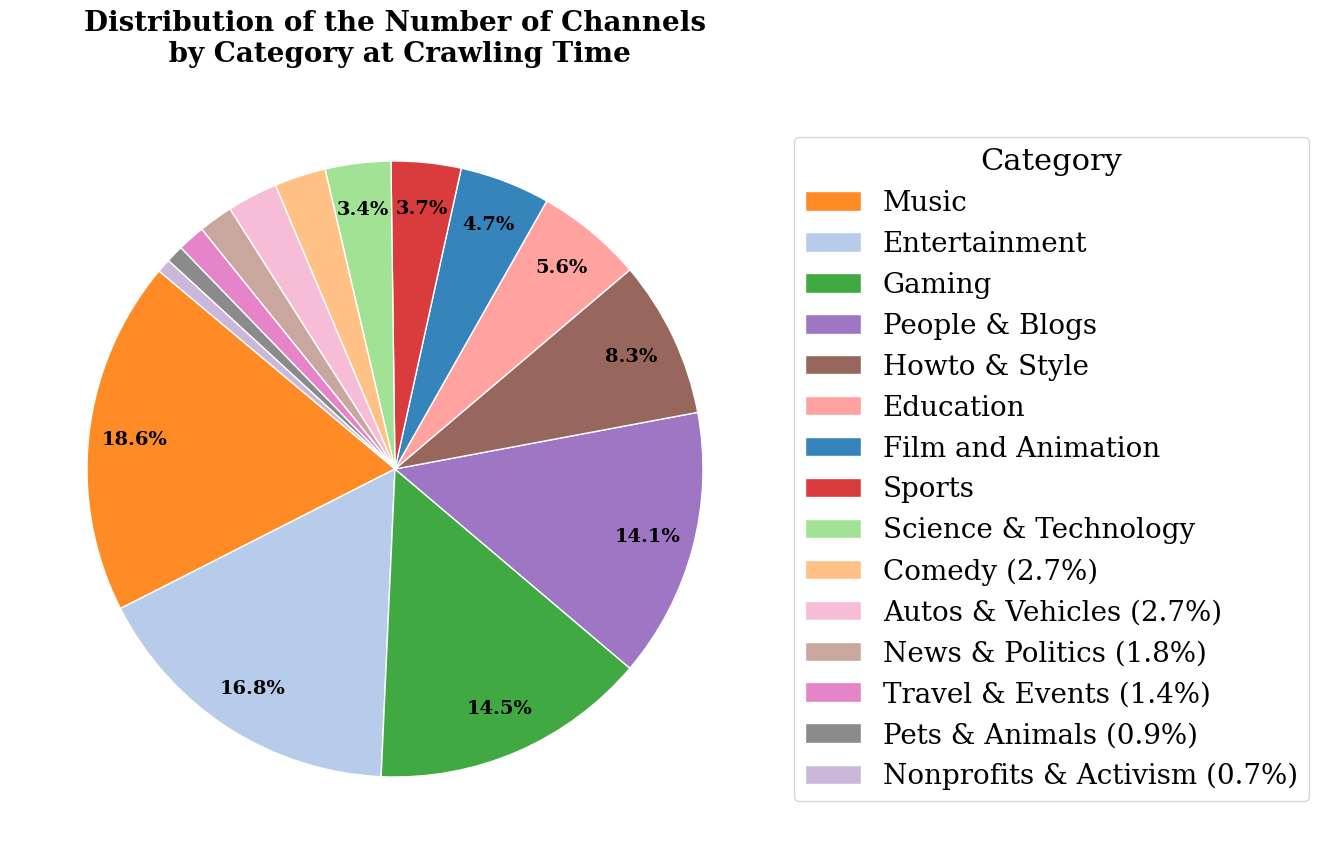

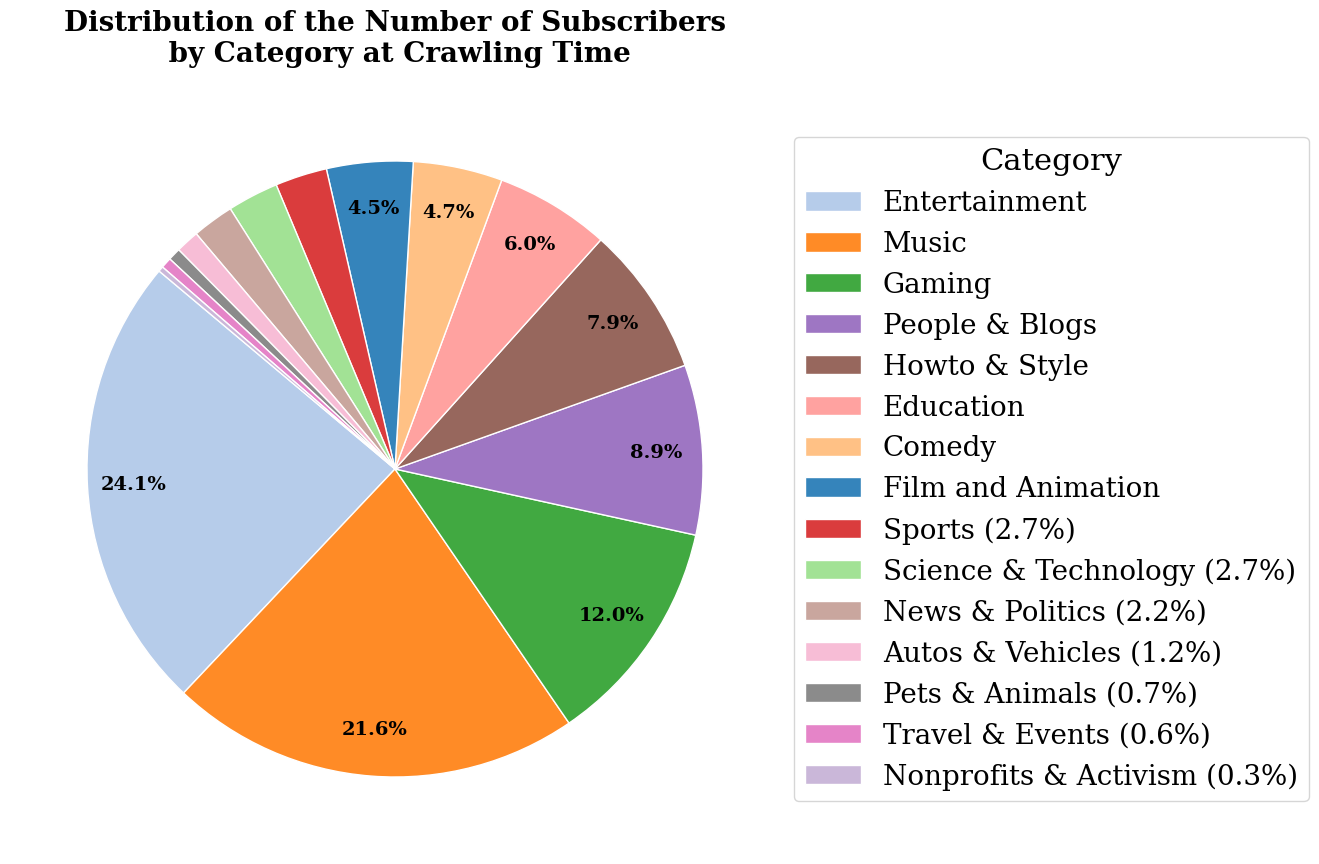

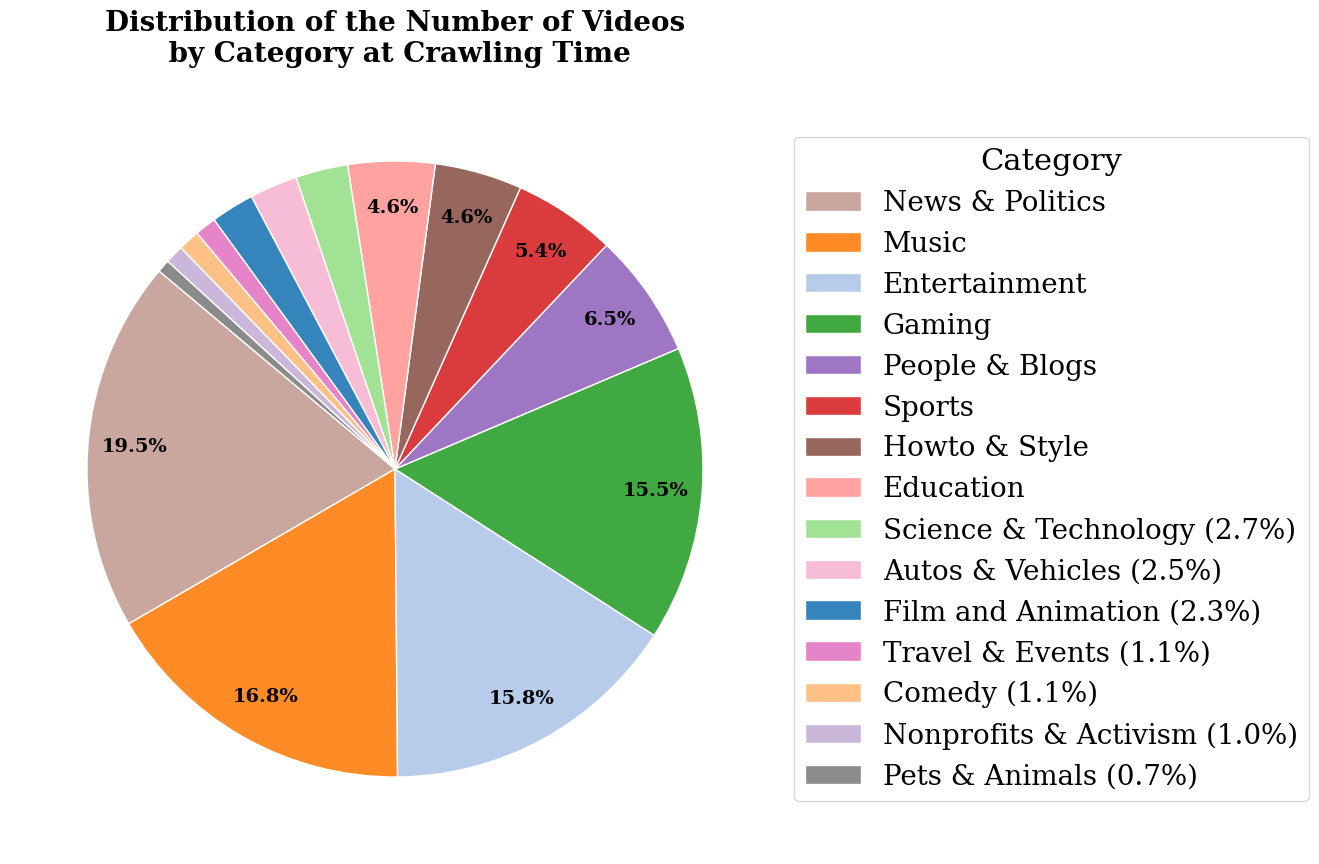

In [27]:
# Get the general statistics of the channel dataset
values = [None, "subscribers_cc", "videos_cc"]
titles = ["Channels", "Subscribers", "Videos"]

for value, title in zip(values, titles):
    data_utils.plot_pie_chart(df=df_channels, 
                              column="category_cc", 
                              values=value, 
                              title=f"Distribution of the Number of {title}\n by Category at Crawling Time")

These Pie Charts justify the choice of Music and Entertainment for our comparison as they are the biggest on YouTube. At crawling time, together they cumulate $\sim$ 35% of the total number of channels and $\sim$ 45% of the total number of subscribers. \
However, they do not necessarily have the highest number of videos. The 4 greatest categories are (in decreasing order): News & Politics > Music > Gaming > Entertainment. This can be explained by the fact that News and Gaming channels output videos frequently, even though they might not amass as many views and/or subscribers.

In [28]:
# For each category, save the channels in a separate file 
data_utils.save_data_grouped_by_category(df_channels, 
                                         column="category_cc", 
                                         output_dir=CHANNELS_PATH, 
                                         overwrite=True, 
                                         verbose=False)

### 2.1.B) Example of Channel Data: The Music Category

For each category, we can analyze the distribution of the various features. We can also compute the correlation between these quantities. Here, we focus on the `Music` category.

Displaying statistics to study the YouTube channels in the category: Music

The category Music consists of 29166 channels.
The DataFrame occupies 6.52 MB.



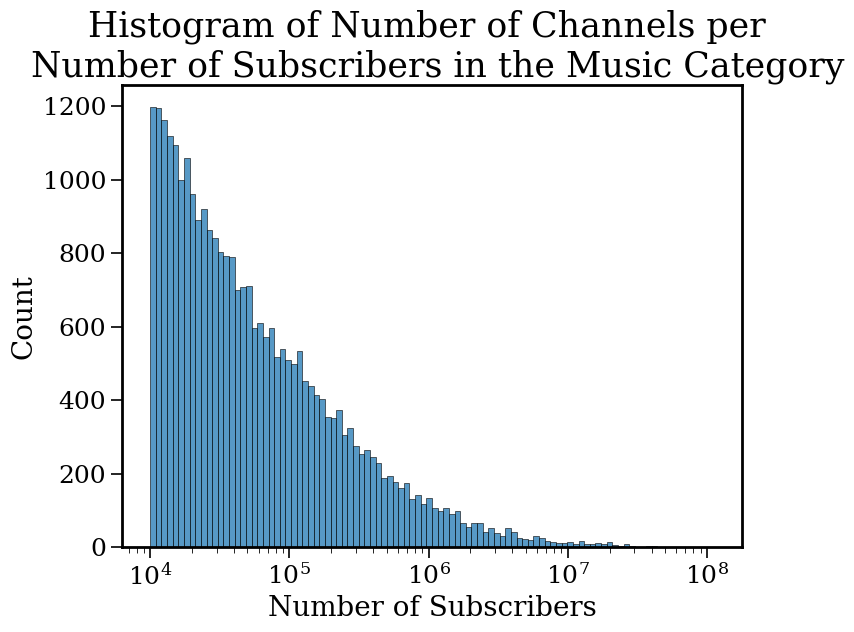

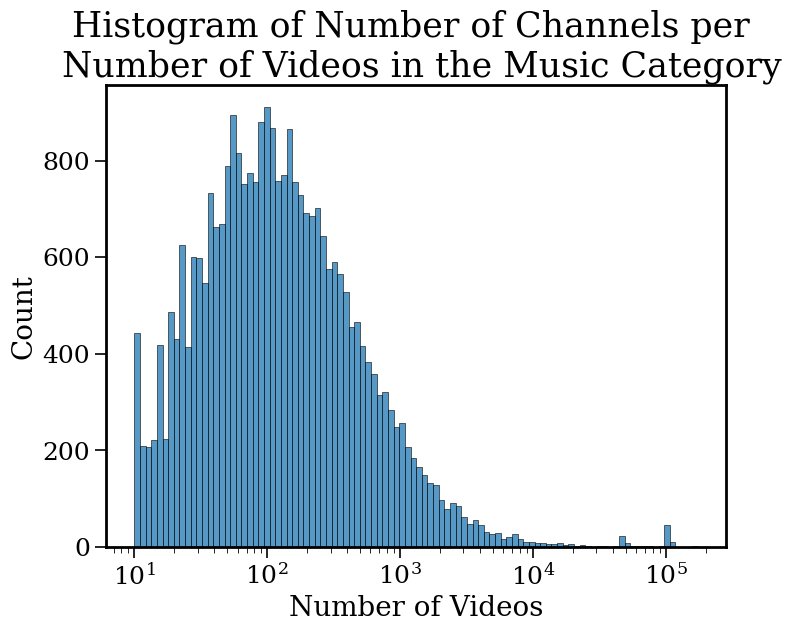

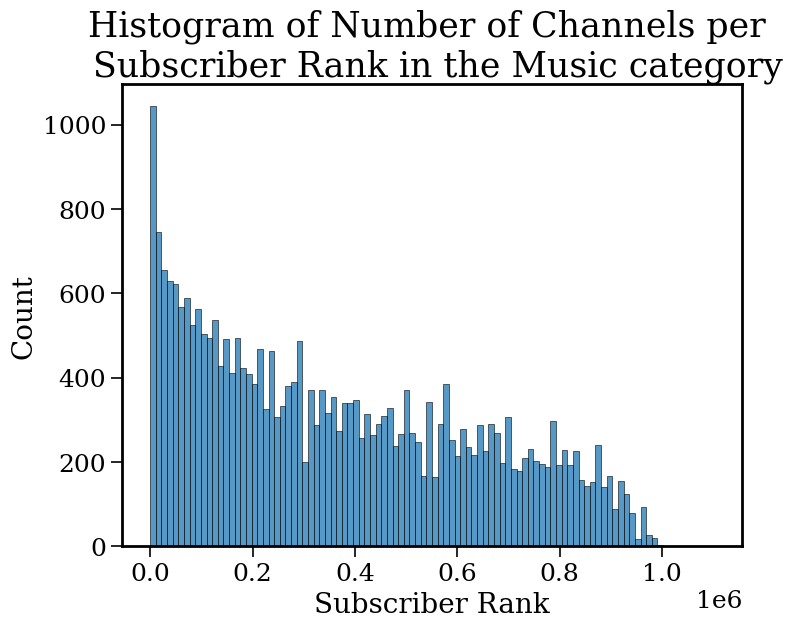

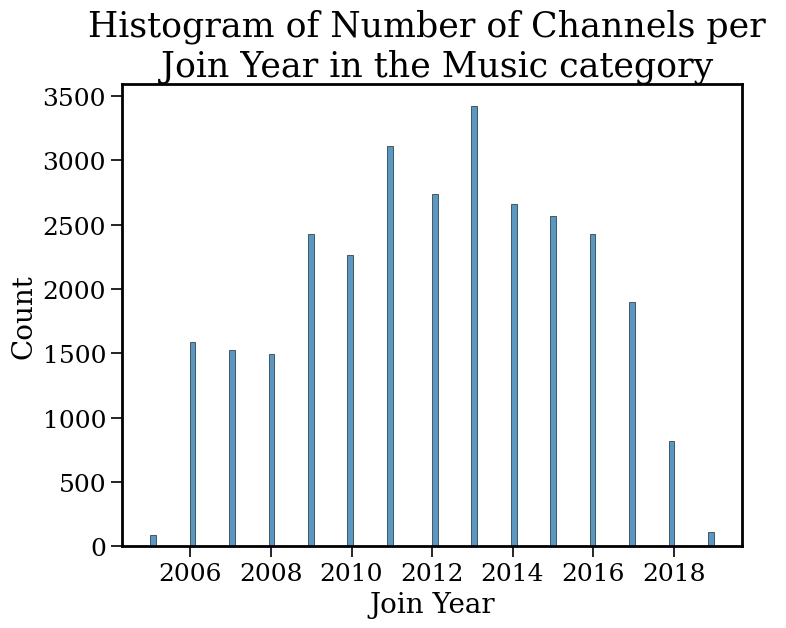

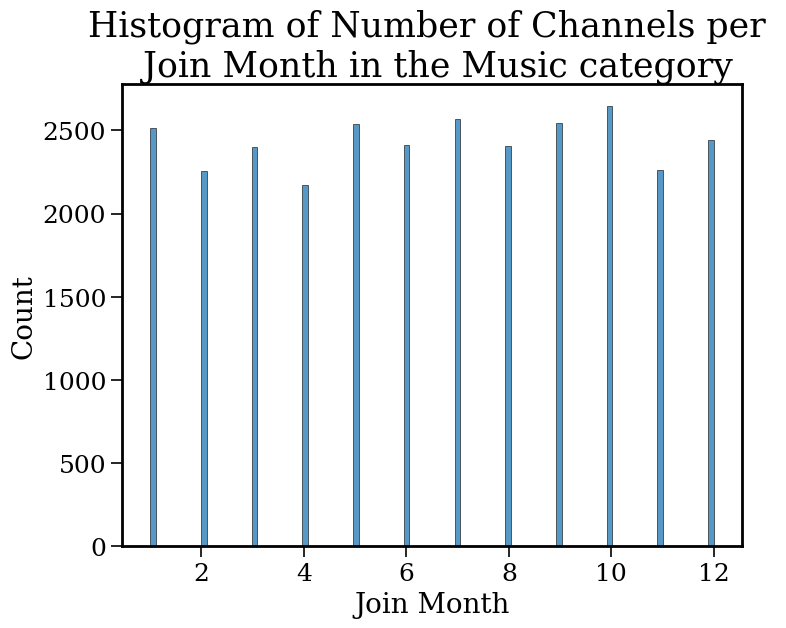

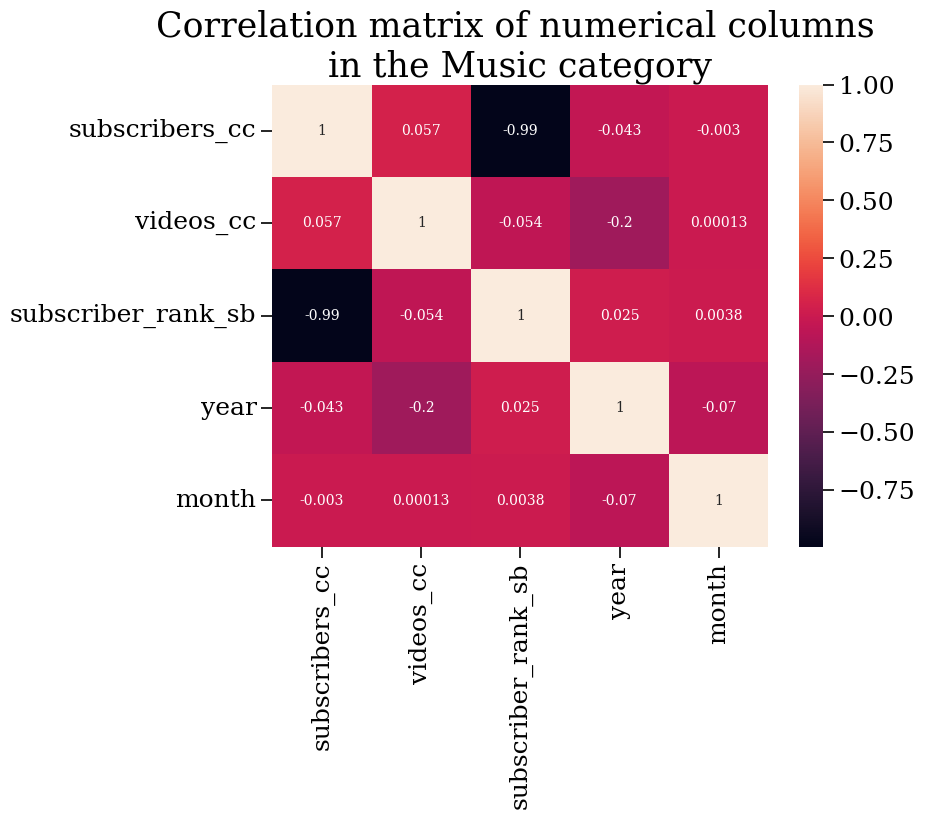

Type    count                           mean  \
join_date           datetime64[ns]    29166  2012-08-04 05:46:59.419872512   
subscribers_cc               int32  29166.0                  280694.723719   
videos_cc                    int32  29166.0                     631.424913   
subscriber_rank_sb         float32  28288.0                   364583.90625   
category_cc         string[python]      NaN                            NaN   
channel             string[python]      NaN                            NaN   
name_cc             string[python]      NaN                            NaN   

                              std                  min                  25%  \
join_date                     NaN  2005-06-25 00:00:00  2010-01-25 00:00:00   
subscribers_cc      1504048.86949              10000.0              18200.0   
videos_cc             5243.791998                 10.0                 46.0   
subscriber_rank_sb     270165.875                 13.0             124611.5   
category_cc                   NaN                  NaN                  NaN   
channel                       NaN                  NaN                  NaN   
name_cc                       NaN                  NaN                  NaN   

                                    50%                  75%  \
join_date           2012-10-02 00:00:00  2015-03-20 00:00:00   
subscribers_cc                  40000.0             127060.0   
videos_cc                         111.0                293.0   
subscriber_rank_sb             316245.5            580614.75   
category_cc                         NaN                  NaN   
channel                             NaN                  NaN   
name_cc                             NaN                  NaN   

                                    max  Missing values  Percentage missing  
join_date           2019-08-15 00:00:00               0            0.000000  
subscribers_cc              112139463.0               0            0.000000  
videos_cc                      175300.0               0            0.000000  
subscriber_rank_sb            1101245.0             878            3.010355  
category_cc                         NaN               0            0.000000  
channel                             NaN               0            0.000000  
name_cc                             NaN               2            0.006857

In [29]:
category = "Music"
df_channel_music = pd.read_csv(f"{CHANNELS_PATH}/{category}.tsv.gz", sep='\t', compression='gzip')
df_channel_music = data_utils.cast_df(df_channel_music, type='channel')

data_utils.get_stats_on_category(df_channel_music,
                                 type='channel', 
                                 category_name=category, 
                                 corr_method='spearman', 
                                 verbose=False)

## 2.2. Time Series Dataset Analysis

In [30]:
df_time_series = pd.read_csv(f"{DATA_PATH}/time_series.tsv.gz", sep="\t", compression="gzip")
df_time_series.head(3)

channel            category             datetime  \
0  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-03 00:00:00   
1  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-10 00:00:00   
2  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-17 00:00:00   

           views    delta_views         subs  delta_subs  videos  \
0  202494.555556       0.000000   650.222222    0.000000       5   
1  394085.666667  191591.111111  1046.000000  395.777778       6   
2  835393.750000  441308.083333  1501.500000  455.500000       6   

   delta_videos  activity  
0             0         3  
1             1         1  
2             0         1

In [31]:
# For each category, save the time series in a separate file if overwrite is set to True
data_utils.save_data_grouped_by_category(df_time_series, 
                                         column="category", 
                                         output_dir=TIME_SERIES_PATH,
                                         overwrite=False, 
                                         verbose=False)

KeyboardInterrupt: 

### 2.2.A) Example of Time Series Data: The evolution of some famous channels

Let's focus on the `Music` category and particular channels. First, since we only have access to the channel ids (via the `channel` column), we need to merge the channel ids with the channel names available in the `df_channels` dataset under the `name_cc` column.

In [11]:
category = "Music"

# Load the Music time series
df_music_time_series = pd.read_csv(f"{TIME_SERIES_PATH}/{category}.tsv.gz", sep='\t', compression='gzip')
df_music_time_series = data_utils.cast_df(df_music_time_series, type='time_series')

# Load the Music channels
df_music_channels = pd.read_csv(f"{CHANNELS_PATH}/{category}.tsv.gz", sep='\t', compression='gzip')
df_music_channels = data_utils.cast_df(df_music_channels, type='channel')

# Add the channel names to the time series dataset by merging the two datasets
df_music_time_series = data_utils.merge_channel_name(df_music_time_series, df_music_channels, subscriber_rank=True)

In [12]:
df_music_time_series[["channel", "name_cc", "delta_views"]].sample(3)

channel       name_cc   delta_views
51205    UCNyhY2w6eZe5-VOYK8uvIDw       Mol Mic  34908.815126
3520729  UCUIijn8EdtcTjNt4tbT13qw        ok boi   5546.068182
108986   UCq4bZeYa-eJZjVv791zWpOw  David Larson   8297.870370

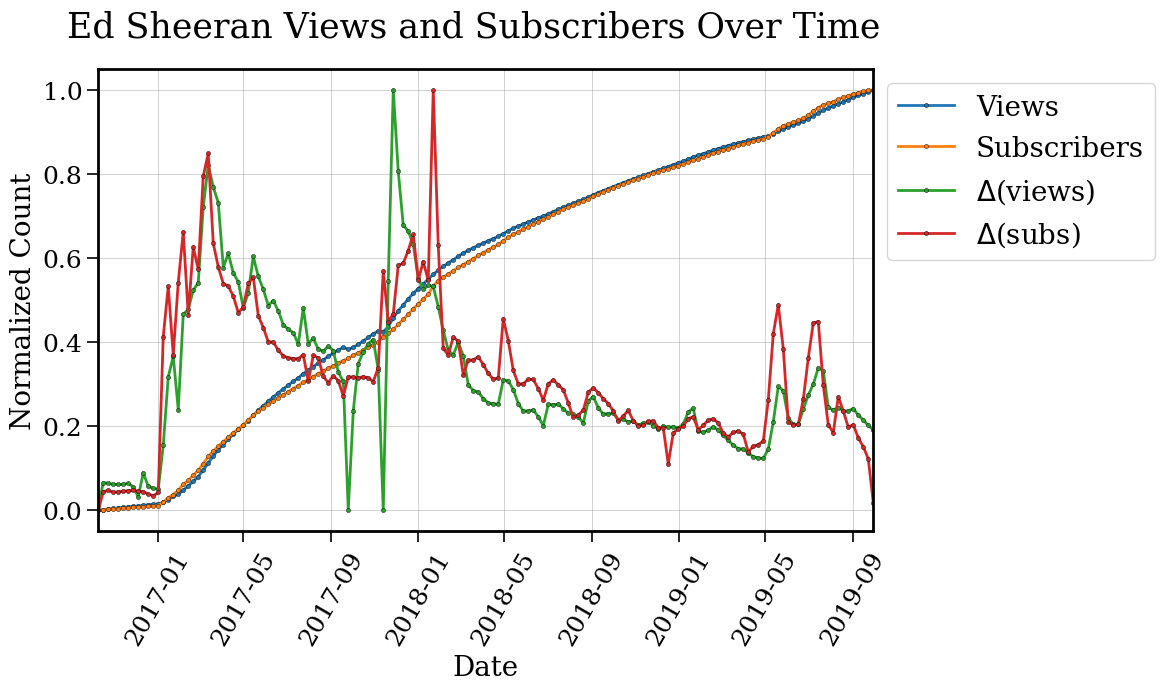

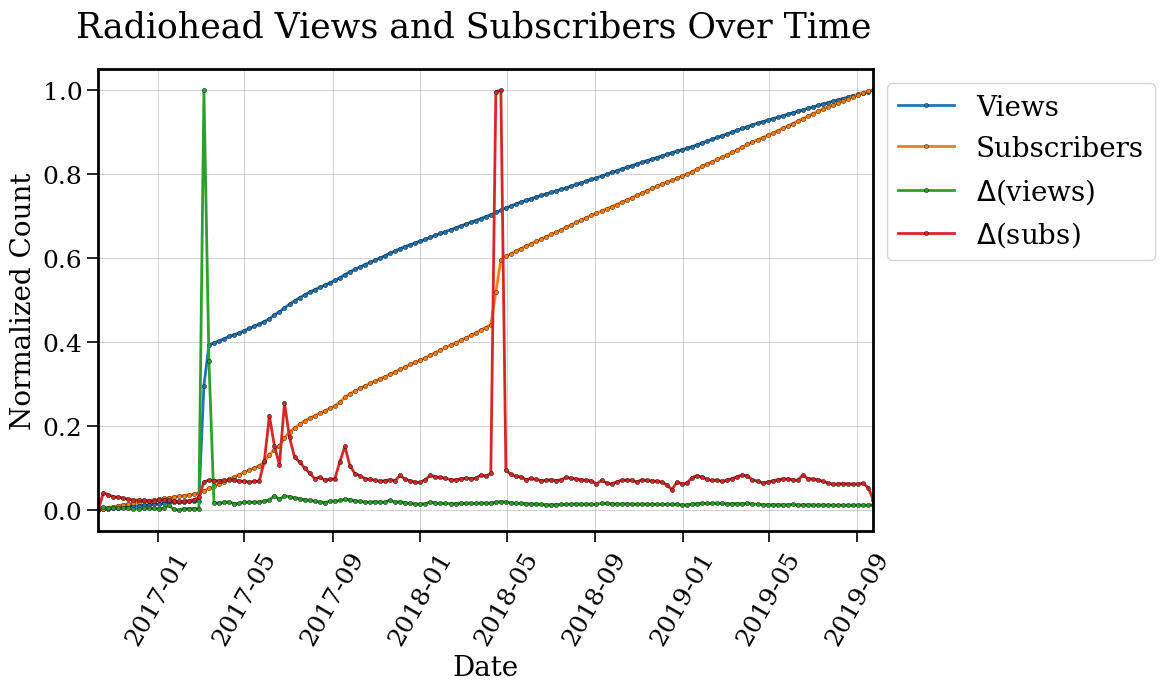

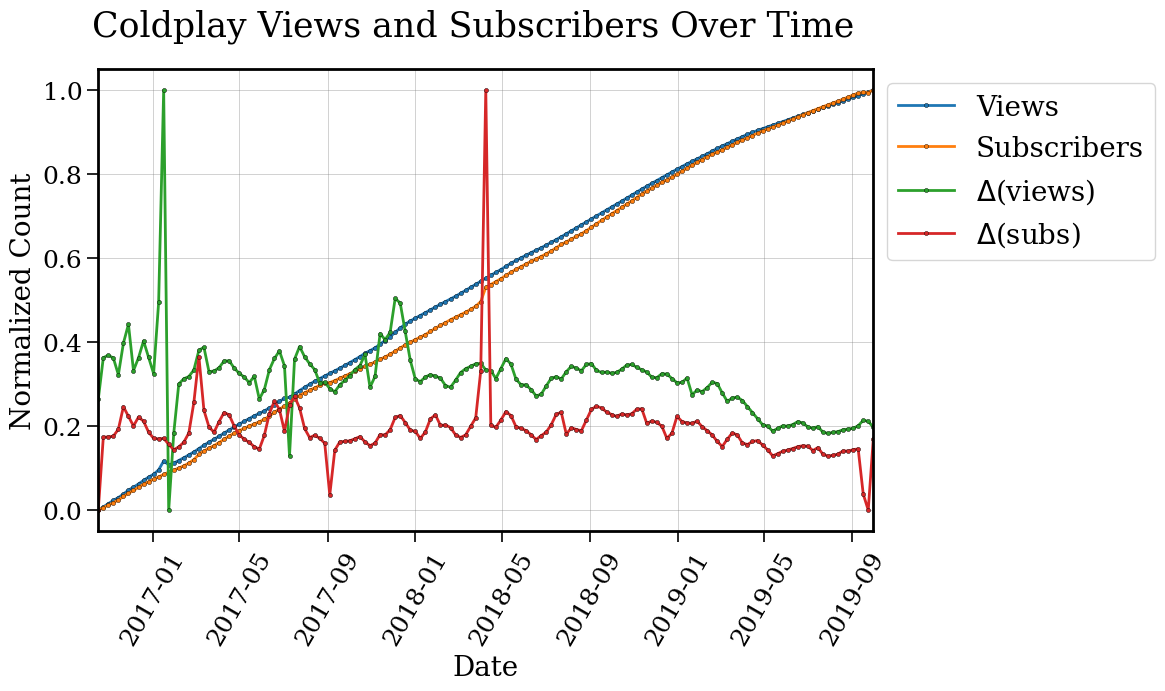

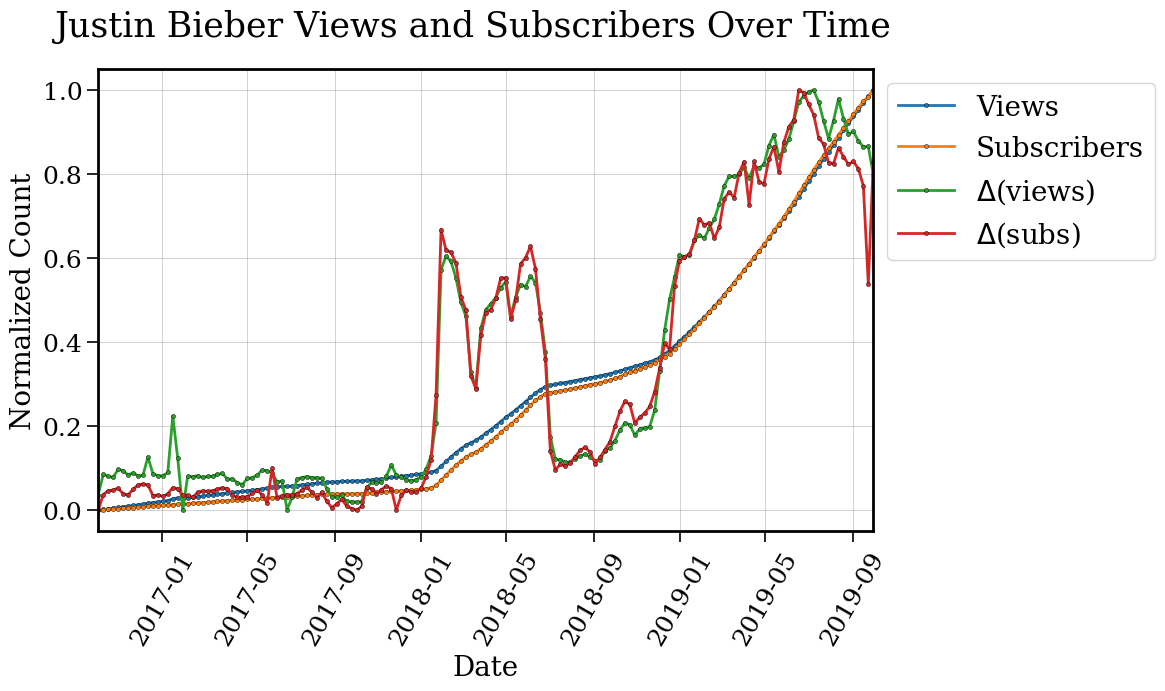

In [13]:
# Here we use normalized data to compare the evolution trend of different channels (not the specific values)
channel_names = ["Ed Sheeran", "Radiohead", "Coldplay", "Justin Bieber"]
for channel_name in channel_names:
    data_utils.plot_channel_time_series(df=df_music_time_series,
                                        channel_name=channel_name,
                                        datetime_col="datetime",
                                        quantities_to_plot=["views", "subs", "delta_views", "delta_subs"],
                                        normalize=True,
                                        palette="tab10",
                                        markers=["."],
                                        title=f"{channel_name} Views and Subscribers Over Time")

In the time-series given above, it is interesting to note the tall peaks in $\Delta(views)$ and $\Delta(subs)$, in particular for Ed Sheeran, Radiohead and Coldplay. A more in depth analysis of this feature will have to be performed to see if it is random, if it is due to external events (external to the dataset), or if there is some hidden mechanism linking these peaks between different artists.

### 2.2.B) Various distributions of the time series data

As for the channel dataset, we can analyze the distribution of the various features in the time series dataset. Here, we again focus on the `Music` category. 

We start by plotting the distribution of the `delta_views`, `delta_subs`, and `delta_videos`, these represent the weekly gains (or losses) in views, subscribers, and videos, respectively.

**Observations for the Music Category:**
- Both the distributions of $\Delta$(views) and $\Delta$(subs) seem close to log-normal distributions (the latter is a bit skewed to the left), with a sharp peak at zero (meaning that many channels do not gain or lose many views or subscribers weekly). This peak could has different contributions: for instance, "dead" channels that do not post new content, or channels that upload monthly or yearly. 
- The distribution of $\Delta$(videos) is power-law distributed as can be seen from the log-log plot.

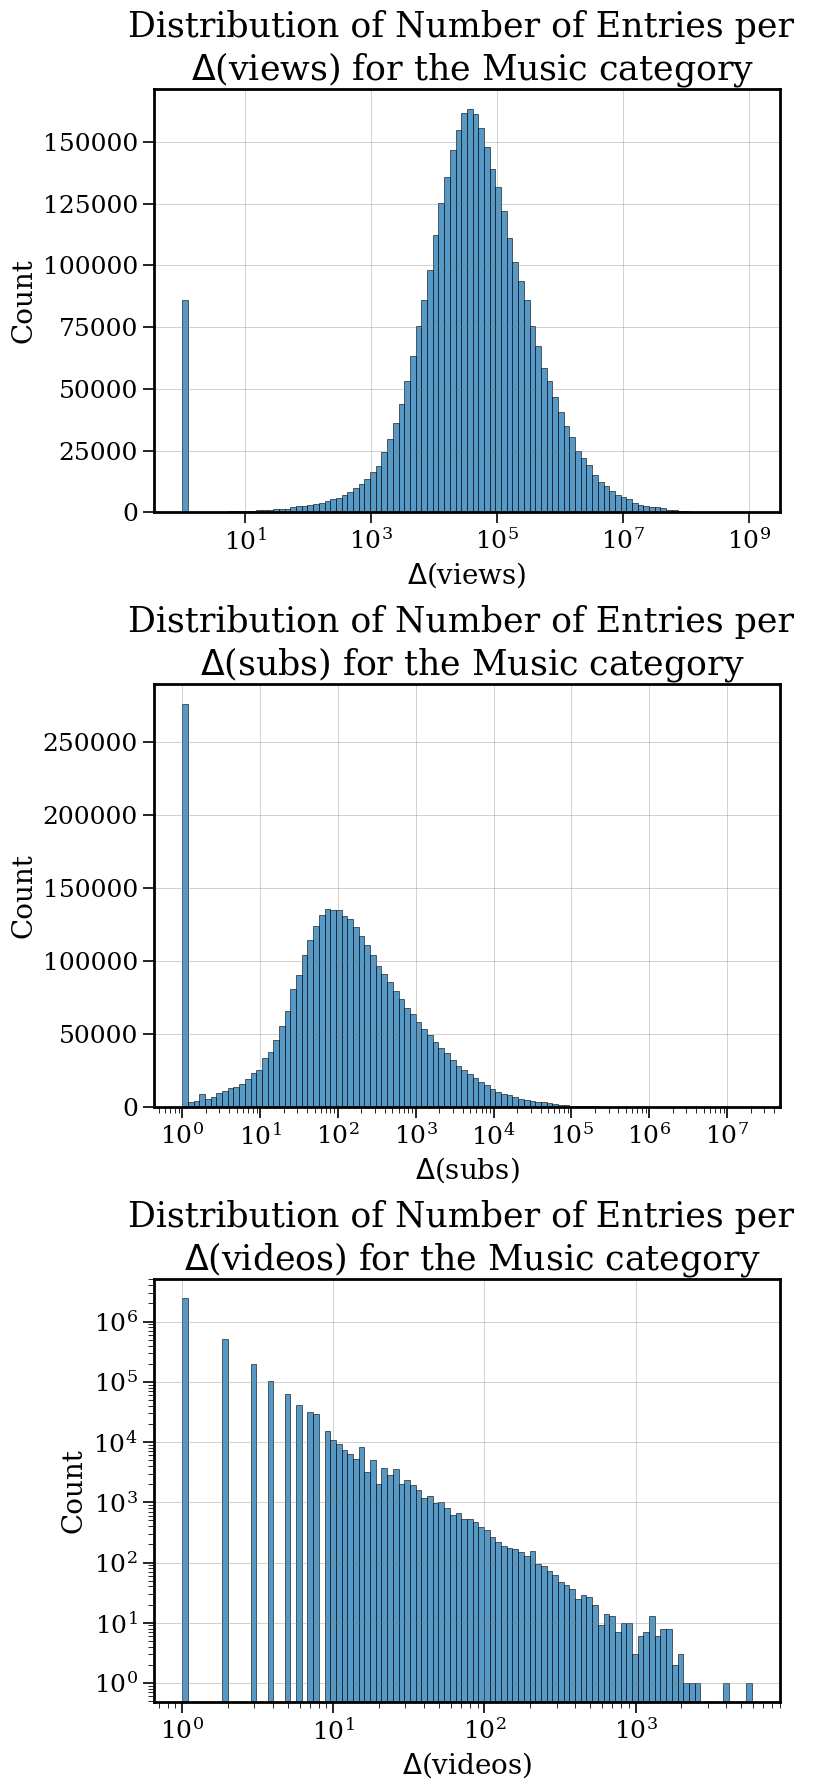

Summary statistics for the ['delta_views', 'delta_subs', 'delta_videos']:
        delta_views    delta_subs  delta_videos
count  3.532411e+06  3.532411e+06  3.532411e+06
mean   5.024196e+05  1.455334e+03  2.250262e+00
std    4.831397e+06  3.365696e+04  1.012890e+01
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.270512e+04  3.630556e+01  1.000000e+00
50%    4.314838e+04  1.168889e+02  1.000000e+00
75%    1.612702e+05  4.424583e+02  2.000000e+00
max    1.104146e+09  2.053974e+07  5.860000e+03


In [26]:
data_utils.plot_category_distribution(df_data=df_music_time_series,
                                      columns=["delta_views", "delta_subs", "delta_videos"],
                                      category="Music",
                                      x_logs=[True, True, True],
                                      y_logs=[False, False, True],
                                      kind="hist",
                                      print_summary=True)

### 2.2.C) Comparison of the distributions across different categories

Something that is more interesting is to compare these distributions across different categories. Let's plot the `delta_views`, `delta_subs`, and `delta_videos` distributions for different categories. 

For example, we expect that the "News & Politics" category has a higher $\Delta$(videos) distribution compared to other categories, as news channels tend to upload multiple videos daily.

The cell bellow plots the histograms for the `delta_views`, `delta_subs`, and `delta_videos` distributions for the categories `News & Politics`, `Travel & Events`, `Music`, and `Education`. We only plot the markers to avoid the overlap of the bars.

We indeed observe that the `News & Politics` category has a heavier tail for the `delta_videos` distribution compared to the other categories. 

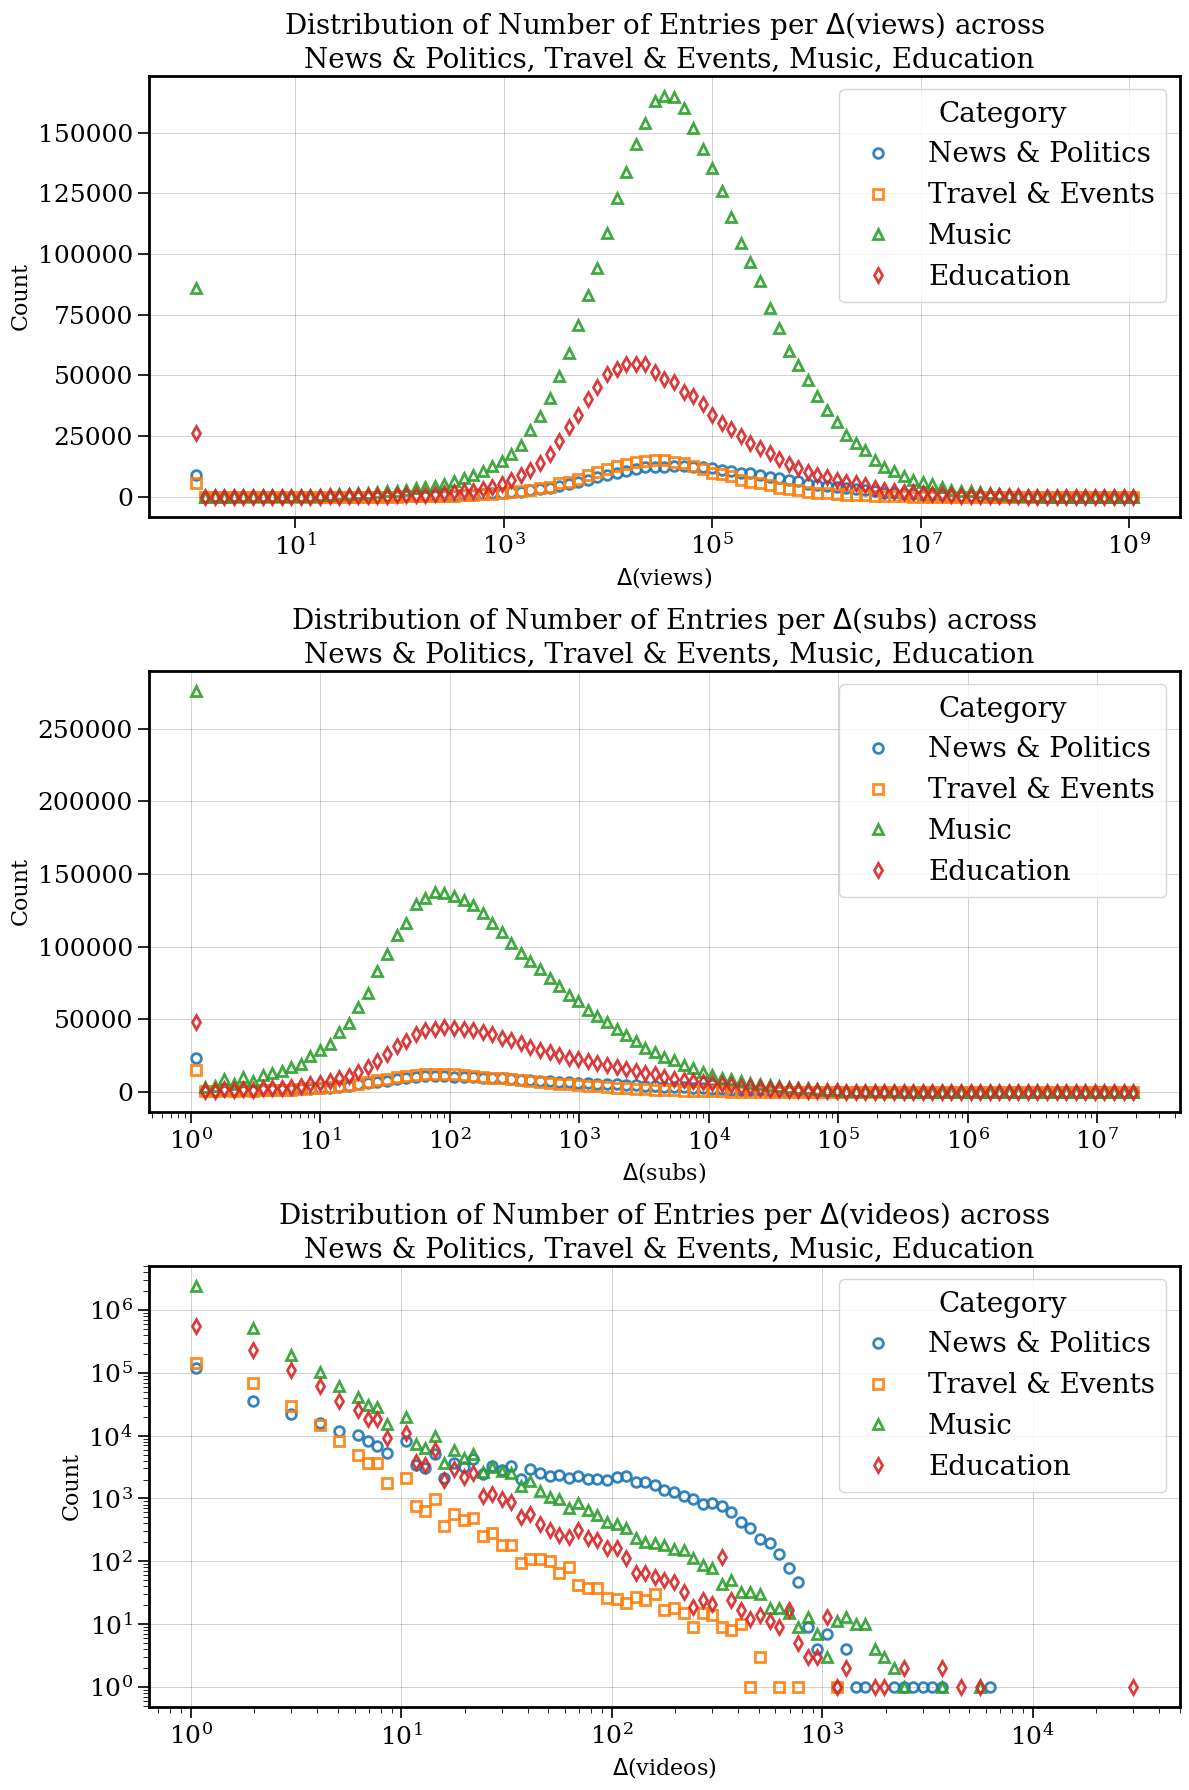

In [25]:
categories = ["News & Politics", "Travel & Events", "Music", "Education"]
data_utils.compare_distribution_across_categories(df_time_series,
                                                  columns=["delta_views", "delta_subs", "delta_videos"],
                                                  hue="category",
                                                  categories=categories,
                                                  x_logs=[True, True, True],
                                                  y_logs=[False, False, True],
                                                  kind="hist", 
                                                  marker_only=True)

On the graphs above, we observe that the number of entries around the median for $\Delta(views)$ and $\Delta(subs)$ is dominated by the Music category, as expected. However when considering $\Delta(videos)$, the number of entries with $\Delta(videos)>10^2$ stays higher for News & Politics, whereas it decreases for the other categories. Once again, this is not surprising as News & Politics channels tend to upload more frequently.

## 2.3 Video Metadata Dataset Analysis

<div style="padding: 15px 20px; border-left: 3px solid red; background-color: #FFC7C7; border-radius: 20px; color: #424242;">
    
**Warning:** The cell below should be run only once (it takes a long time to write the files ~1h30min)
</div>

In [16]:
# Process the metadata file by saving each category in a separate file
# data_utils.process_metadata(f"{DATA_PATH}/yt_metadata.jsonl.gz",
#                             output_dir=VIDEO_METADATA_PATH,
#                             column_to_group="categories",
#                             chunk_size=10_000)

### 2.3.A) Example of Video Metadata Statistics for the Music Category

In [ ]:
# creating a dataframe for each category we are interested in (Music and Entertainment here)

dataframes = {}

categories = ['Entertainment', 'Music'] 

for category in categories:

    df = pd.read_parquet(f"{VIDEO_METADATA_PATH}/{category}.parquet.gz")
    df = data_utils.cast_df(df, type='video_metadata')
    df.dropna(inplace=True)
    
    dataframes[f'df_metadata_{category}'] = df

df_music = dataframes['df_metadata_Music'].copy(deep=True)
df_entertainment = dataframes['df_metadata_Entertainment'].copy(deep=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Crucial X6 1/YouNiverse/video_metadata/Entertainment.parquet.gz'

Displaying statistics to study the YouTube videos in the category: music

The category music consists of 8197981 videos.
The DataFrame occupies 14436.76 MB.



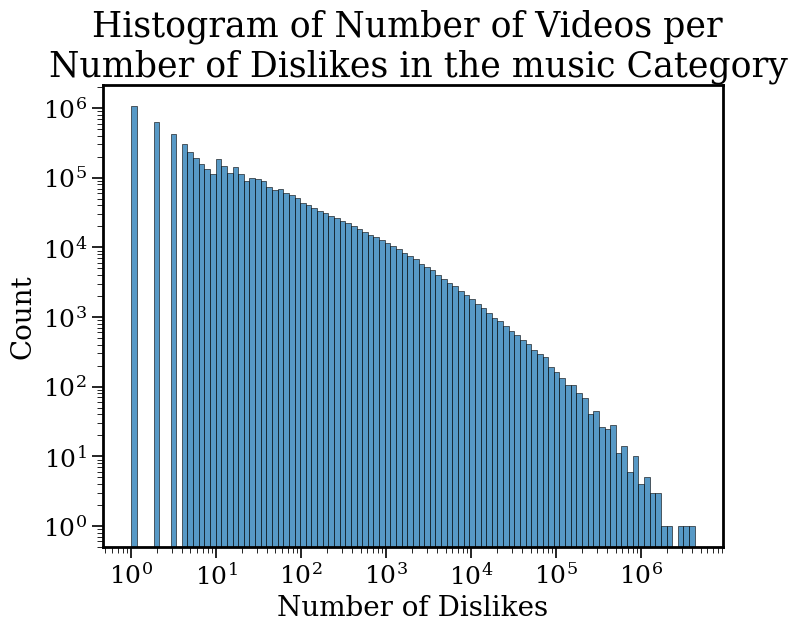

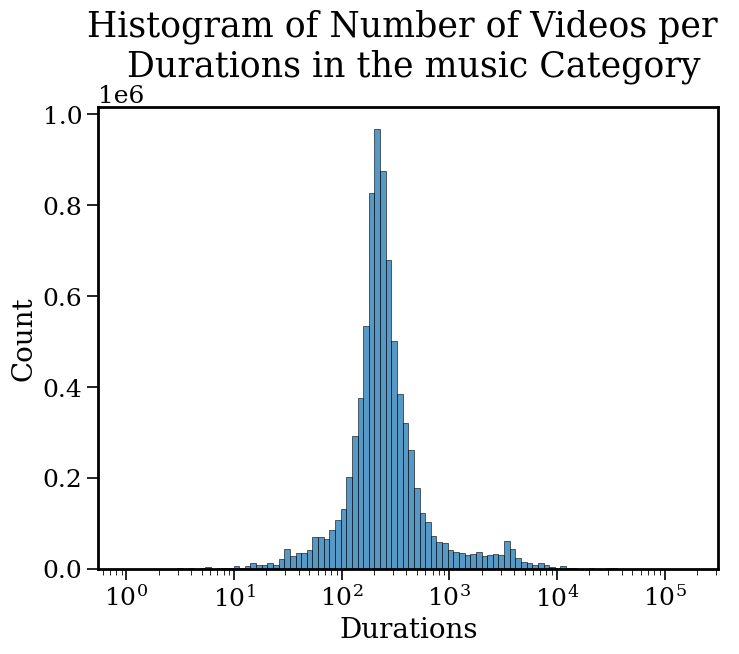

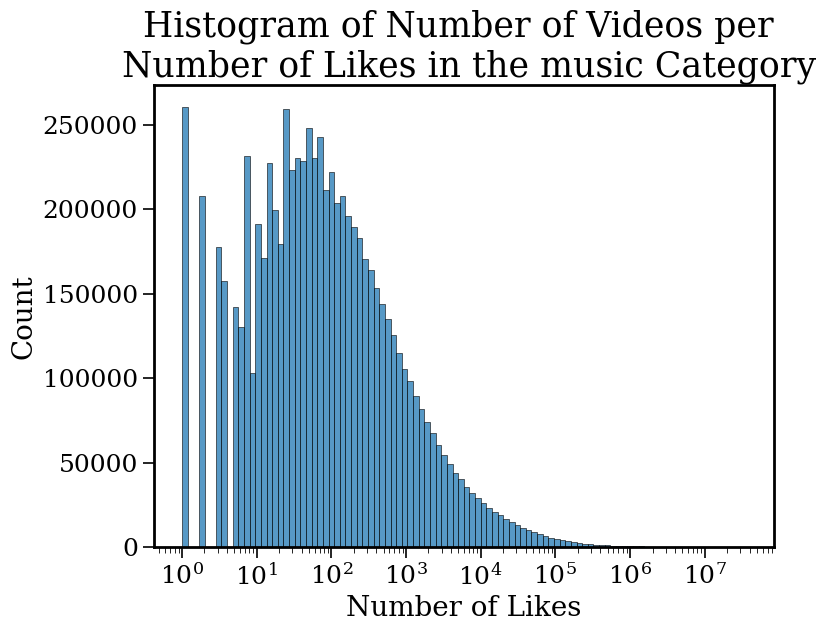

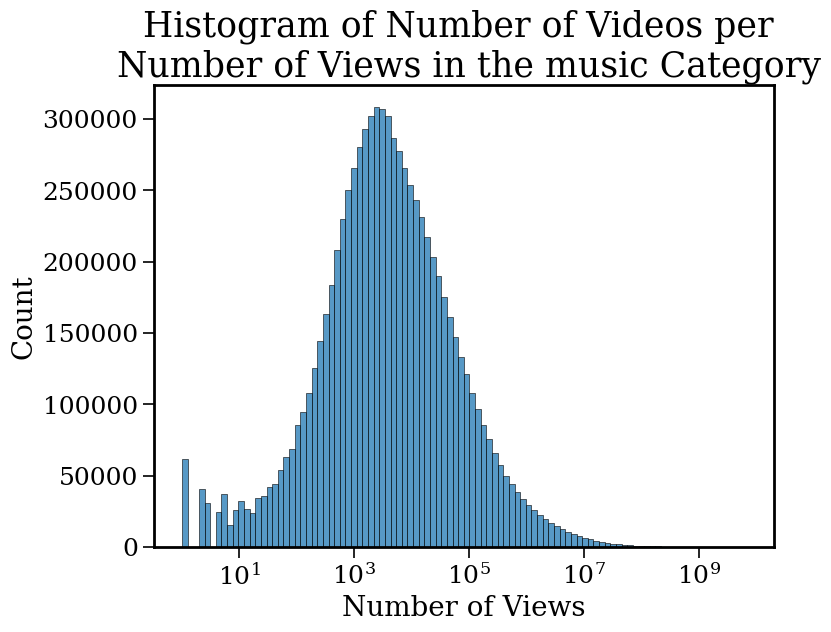

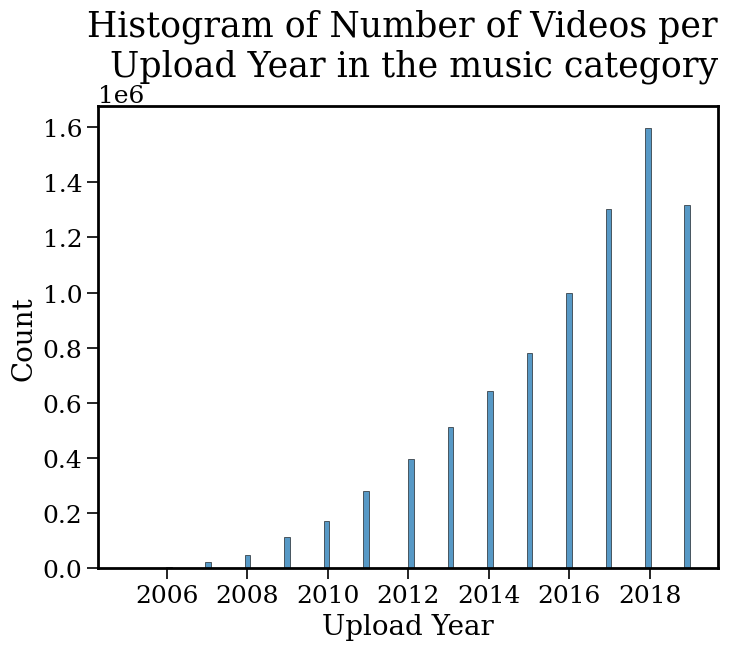

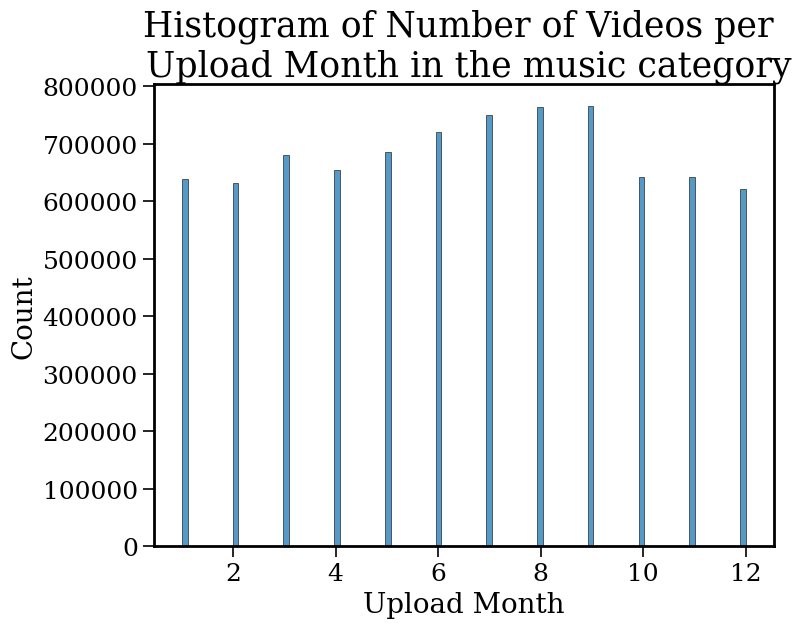

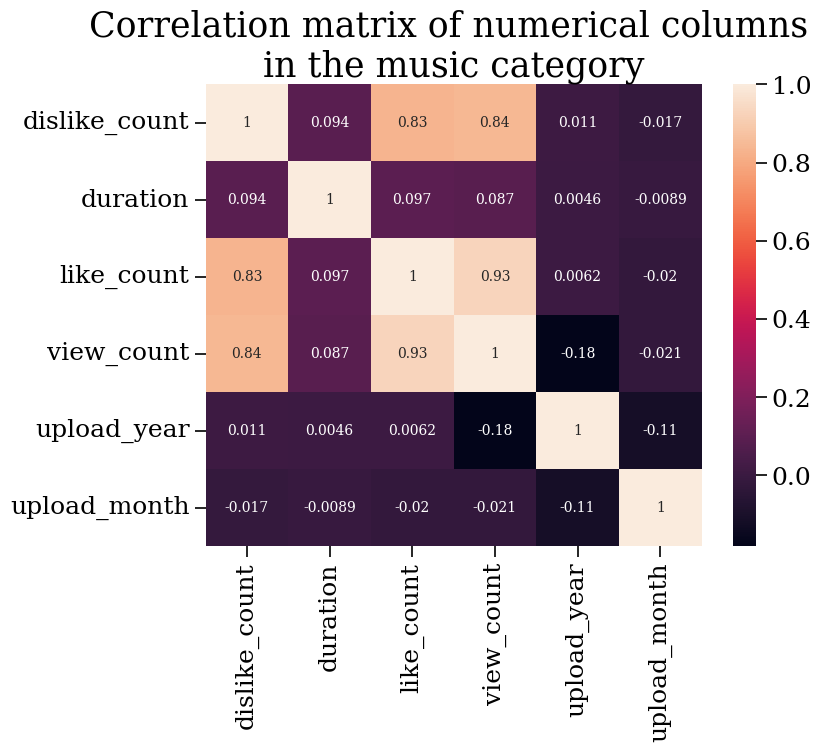

Type      count                           mean  \
crawl_date     datetime64[ns]    8197981  2019-11-10 07:11:01.661946624   
dislike_count         float32  8197981.0                     108.778549   
duration                int32  8197981.0                     470.293198   
like_count            float64  8197981.0                    2350.635442   
upload_date    datetime64[ns]    8197981  2016-06-02 12:59:32.481760256   
view_count            float64  8197981.0                   300966.44338   
categories     string[python]        NaN                            NaN   
channel_id     string[python]        NaN                            NaN   
description    string[python]        NaN                            NaN   
display_id     string[python]        NaN                            NaN   
tags           string[python]        NaN                            NaN   
title          string[python]        NaN                            NaN   

                          std                         min  \
crawl_date                NaN  2019-10-29 16:47:24.970666   
dislike_count     4079.209717                         0.0   
duration          1355.939314                         1.0   
like_count       50933.245053                         0.0   
upload_date               NaN         2005-11-19 00:00:00   
view_count     9202386.102651                         0.0   
categories                NaN                         NaN   
channel_id                NaN                         NaN   
description               NaN                         NaN   
display_id                NaN                         NaN   
tags                      NaN                         NaN   
title                     NaN                         NaN   

                                         25%                            50%  \
crawl_date     2019-11-03 03:01:06.791421952  2019-11-10 09:16:50.808062976   
dislike_count                            0.0                            2.0   
duration                               172.0                          230.0   
like_count                               9.0                           50.0   
upload_date              2014-10-15 00:00:00            2017-02-04 00:00:00   
view_count                             655.0                         3339.0   
categories                               NaN                            NaN   
channel_id                               NaN                            NaN   
description                              NaN                            NaN   
display_id                               NaN                            NaN   
tags                                     NaN                            NaN   
title                                    NaN                            NaN   

                                         75%                         max  \
crawl_date     2019-11-17 10:29:45.057683968  2019-11-23 15:34:17.741614   
dislike_count                            9.0                   4265883.0   
duration                               333.0                    172919.0   
like_count                             268.0                  35287325.0   
upload_date              2018-07-25 00:00:00         2019-11-20 00:00:00   
view_count                           19552.0                6509934494.0   
categories                               NaN                         NaN   
channel_id                               NaN                         NaN   
description                              NaN                         NaN   
display_id                               NaN                         NaN   
tags                                     NaN                         NaN   
title                                    NaN                         NaN   

               Missing values  Percentage missing  
crawl_date                  0                 0.0  
dislike_count               0                 0.0  
duration                    0                 0.0  
like_count                  0 

In [4]:
# Example of Video Metadata Statistics for the Music Category

data_utils.get_stats_on_category(df_music,
                                 type='video_metadata', 
                                 category_name='music', 
                                 corr_method='spearman', 
                                 verbose=False)

### 2.3.B) Comparison of duration distribution for the Music and Entertainment categories

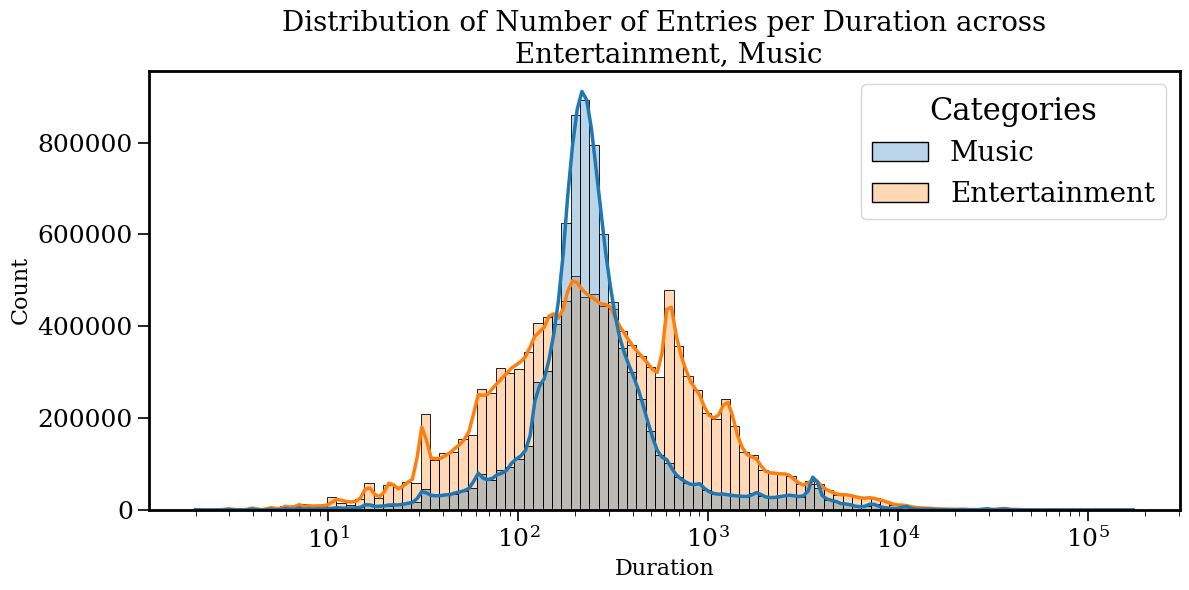

In [ ]:
# Comparison of durations distribution between the two categories

df_metadata_compare =  pd.concat([df_music, df_entertainment], axis=0)
data_utils.compare_distribution_across_categories(df_metadata_compare,
                                                  columns=["duration"],
                                                  categories=categories,
                                                  x_logs=[True],
                                                  y_logs=[False],
                                                  kind="hist",
                                                  hue="categories")

### 2.3.C) Comparison of estimated monetization and viewer engagement distribution for the Music and Entertainment categories

In [7]:
# keeping only "famous" videos, i.e. videos with more views than a threshold

threshold = df_music['view_count'].quantile(0.85) # arbitrarly chosen 

df_famous_music = df_music[df_music['view_count'] > threshold].copy()
df_famous_entertainment = df_entertainment[df_entertainment['view_count'] > threshold].copy()

In [8]:
# Engagement analysis
    # Creation of engagement score for the 2 datasets
df_famous_entertainment['engagement_score'] = (
    ((df_famous_entertainment['like_count'] + df_famous_entertainment['dislike_count']) / df_famous_entertainment['view_count'])
)

df_famous_music['engagement_score'] = (
    ((df_famous_music['like_count'] + df_famous_music['dislike_count']) / df_famous_music['view_count'])
)

# Monetization analysis
    # defining an hypothetic CPM for each category
cpm_music = 1.5 # this one is smaller (see the reference)
cpm_entertainment = 2.0

    # Calculating the estimated revenue for each category
df_famous_music['duration_factor'] = 1 + 0.5 * (df_famous_music['duration'] // 480)  # Facteur pour les durées supérieures à 8 min
df_famous_music['estimated_revenue'] = (
    (df_famous_music['view_count'] / 1000) * cpm_music * df_famous_music['duration_factor']
)

df_famous_entertainment['duration_factor'] = 1 + 0.5 * (df_famous_entertainment['duration'] // 480)  # Facteur pour les durées supérieures à 8 min
df_famous_entertainment['estimated_revenue'] = (
    (df_famous_entertainment['view_count'] / 1000) * cpm_entertainment * df_famous_entertainment['duration_factor']
)

# now every video has a "estimated revenue" and "engagement score" value

df_famous_metadata_compare =  pd.concat([df_famous_music, df_famous_entertainment], axis=0)


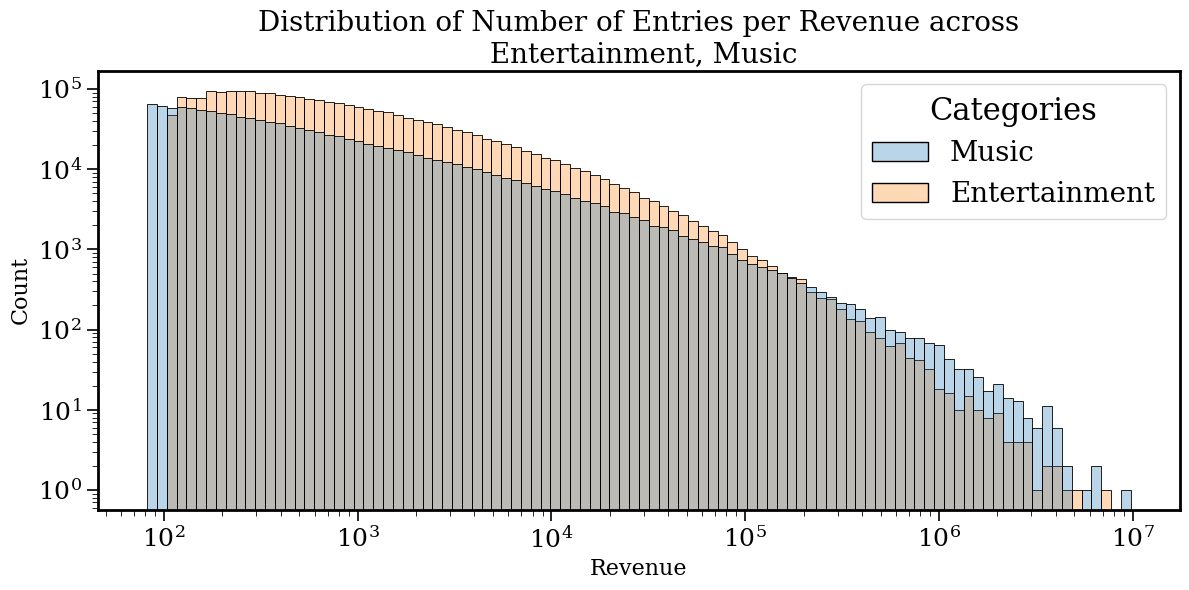

In [9]:
# Comparison of estimated revenue distribution between the two categories

data_utils.compare_distribution_across_categories(df_famous_metadata_compare,
                                                  columns=["estimated_revenue"],
                                                  categories=categories,
                                                  x_logs=[True],
                                                  y_logs=[True],
                                                  kind="hist",
                                                  hue="categories")

                                            

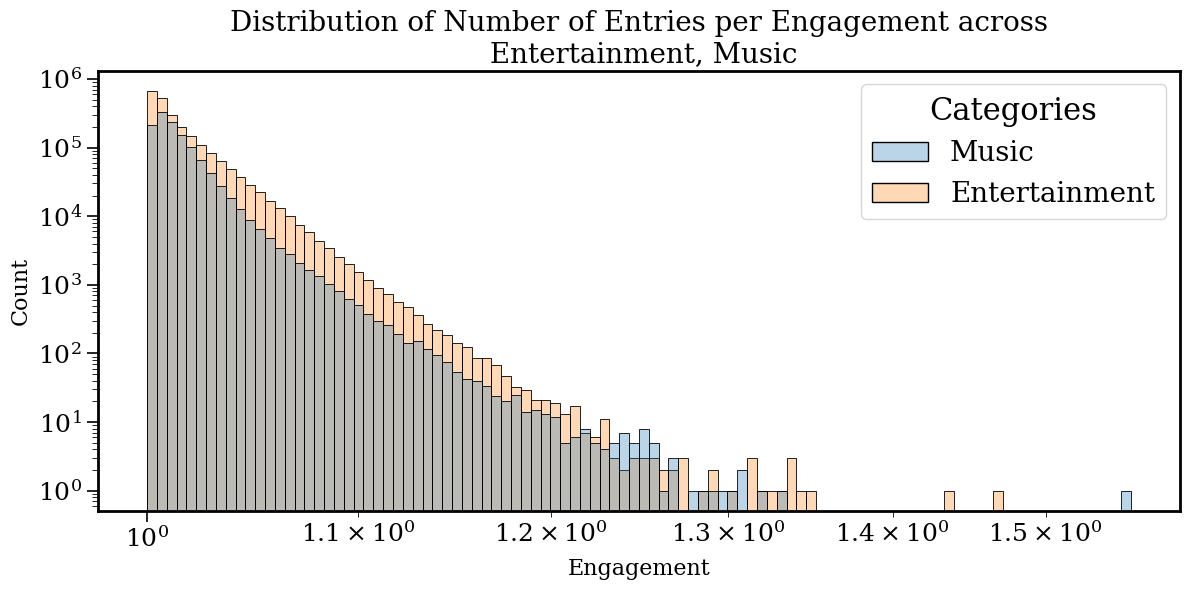

In [10]:
# Comparison of engagement score distribution between the two categories

data_utils.compare_distribution_across_categories(df_famous_metadata_compare,
                                                  columns=["engagement_score"],
                                                  categories=categories,
                                                  x_logs=[True],
                                                  y_logs=[True],
                                                  kind="hist",
                                                  hue="categories")

## 2.4. Comment Dataset Analysis

In [ ]:
df_num_comments = pd.read_csv(f"{DATA_PATH}/num_comments.tsv.gz", sep="\t", compression="gzip")
df_num_comments.sample(3)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Text(0, 0.5, 'Count')

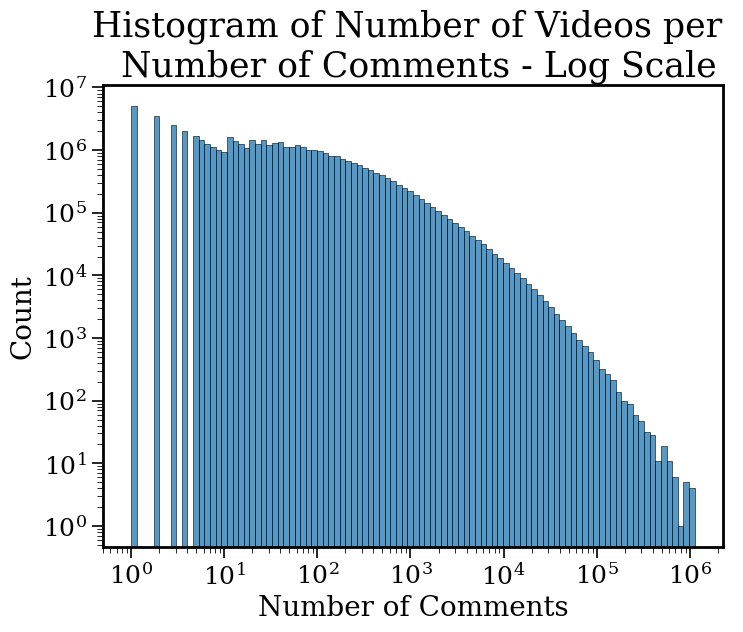

In [20]:
data_utils.plot_histogram_log_scale(
    df=df_num_comments,
    column_name='num_comms',
    title="Histogram of Number of Videos per \n Number of Comments",
    xlabel="Number of Comments",
    ylabel="Count"
)

In [10]:
df_num_comments_authors = pd.read_csv(f"{DATA_PATH}/num_comments_authors.tsv.gz", sep="\t", compression="gzip")
df_num_comments_authors.sample(3)

author  video_id
194952182  250449481         1
360821130  463515274         1
343320962  441032528         6

Text(0, 0.5, 'Count')

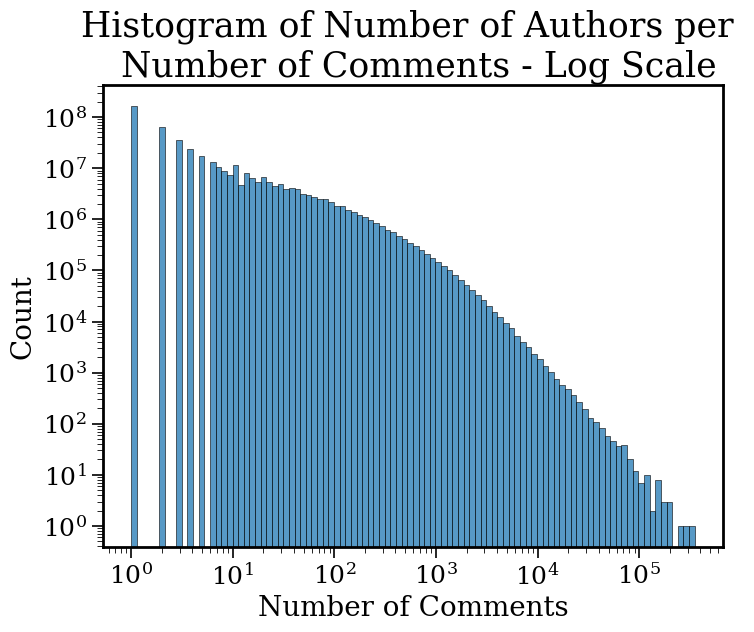

In [18]:
data_utils.plot_histogram_log_scale(
    df=df_num_comments_authors,
    column_name='video_id',
    title="Histogram of Number of Authors per \n Number of Comments",
    xlabel="Number of Comments",
    ylabel="Count"
)

#### Note on the comments dataset

The comments dataset is very large and therefore we have not loaded it here into pandas. If we need to use this dataset in its entirety (and not just the num_comments and num_comments_authors datasets), we will have to load it and filter the data with PySpark. You can uncomment the lines below to load the comments dataset.

In [ ]:
# df_youtube_comments = pd.read_csv(f"{DATA_PATH}/youtube_comments.tsv.gz", sep="\t", compression="gzip")
# df_youtube_comments.sample(3)

# 3. Collaboration Analysis

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Introduction**

In this section, our analysis will focus on collaborations. We have essentially two questions:

1. Does collaboration have, on average, a beneficial effect on the number of views, likes, and dislikes?
2. Is there a link between a channel's collaboration rate and its popularity?

For both questions, we will examine the Music and Entertainment categories.

For example, assuming that collaboration has, on average, a beneficial impact on views, likes, and dislikes for both categories, we could compare the magnitude of this benefit between Music and Entertainment. If collaborations in the Music category lead to a significant increase in views and likes compared to those in the Entertainment category, this could indicate that collaborations are particularly effective in attracting and engaging the audience in the musical field. Conversely, if the benefits are more pronounced in the Entertainment category, this could suggest that collaborations there promote more virality and user interaction.

Furthermore, by examining the link between a channel's collaboration rate and its popularity, it would be interesting to determine whether the most popular channels tend to collaborate more frequently. A positive correlation could indicate that collaborations are an effective strategy for increasing visibility and audience. Conversely, the absence of correlation or a negative correlation could suggest that other factors play a more determining role in the popularity of channels.

--- 

**Outline**

**3.1. Processing**  
- We will download and process the necessary data files. We will also filter the data to keep only the most viewed videos in both Music and Entertainment categories.

**3.2. Collaboration Detection: Does Collaboration Have an Overall Beneficial Effect in Terms of Viewership, Number of Likes and Dislikes?**
- We will detect collaborations in both categories and compare the distribution of views, likes and dislikes between collaboration and non-collaboration videos. This will allow us to assess whether collaborations have a beneficial effect on these metrics. 

**3.3. Analysis of Collaboration Rates and Channel Popularity**
- We will define and compute the collaboration ratio for each channel and analyze its distribution in different contexts. This will help us understand the relationship between a channel's collaboration rate and its popularity.

</div>

## 3.1. Processing

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We consider the following files:

**`channels.tsv.gz`**: each row represents an channel and contains the following columns:
- `category_cc`: category of the channel
- `join_date`: join date of the channel
- `channel`: channel id (uniquely defined)
- `name_cc`: name of the channel
- `subscribers_cc`: number of subscribers
- `videos_cc`: number of videos.
- `subscriber_rank_sb`: rank in terms of number of subscribers

**`yt_metadata.jsonl.gz`**: each row represents a video and contains the following columns:
- `categories`: category of the video
- `channel_id`: channel id
- `crawl_date`: date of the crawl
- `description`: description of the video
- `dislike_count`: number of dislikes
- `display_id`: the video id (uniquely defined)
- `duration`: duration of the video
- `like_count`: number of likes
- `tags`: tags of the video
- `title`: title of the video
- `upload_date`: date of the upload
- `view_count`: number of views

</div>

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We start by filtering the `yt_metadata.jsonl.gz`file to only keep the videos that belong to the Music and Entertainment categories. We then create a new file `yt_metadata_filtered.jsonl.gz` that contains the filtered entries. 

</div>

In [ ]:
# Only keep Music and Entertainment Videos
chunk_size = 500_000
# data_utils.process_data(file_path='data/yt_metadata.jsonl.gz',
#                         chunk_size=chunk_size,
#                         preprocess_func=data_utils.filter_categories,
#                         output_path='data/yt_metadata_filtered.jsonl.gz')

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Now that we have a smaller dataset, we create a new file **`views.jsonl.gz`**. It contains all the entries of the `yt_metadata_filtered.jsonl.gz` dataset. I.e. each entry represents a video, and we only keep columns corresponding to:  
- the video id
- the category
- the number of views

</div>

In [ ]:
# process_views(file_path="data/yt_metadata_filtered.jsonl.gz",
#               output_path="data/views.jsonl.gz",
#               chunk_size=chunk_size)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

This dataset is useful to reduce the size the initial metadata dataset. 

The method is the following: for each category, we only ***keep the most viewed videos that contribute to a fraction $p$ of the total number of views of the category***. To this end, we proceed as follows:
- We sort the videos by the number of views in descending order
- We iterate over the sorted videos and keep adding the views until we reach the fraction $p$ of the total number of views of the category.
- We then keep all the videos that have been added to the selection.

</div>

In [ ]:
# Load the views data
df_views = pd.read_json("data/views.jsonl.gz", lines=True, compression="gzip")

category_map = {"Music": 0, "Entertainment": 1}
df_views_music = df_views[df_views["categories"] == category_map["Music"]]
df_views_entertainment = df_views[df_views["categories"] == category_map["Entertainment"]]

In [ ]:
# Keep only the top p% of the videos
p = 0.95
df_top_p_music = collab_utils.top_p_views(df_views_music, p)
df_top_p_entertainment = collab_utils.top_p_views(df_views_entertainment, p)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can now print and plot the results of the filtering step.

</div>

Top 95.00% of videos
------------------------------------------------------------------------------
Category        Original Number of Videos      Top Videos           Fraction  
------------------------------------------------------------------------------
Music           8197981                        541108               6.60%     
Entertainment   12015676                       1782414              14.83%    


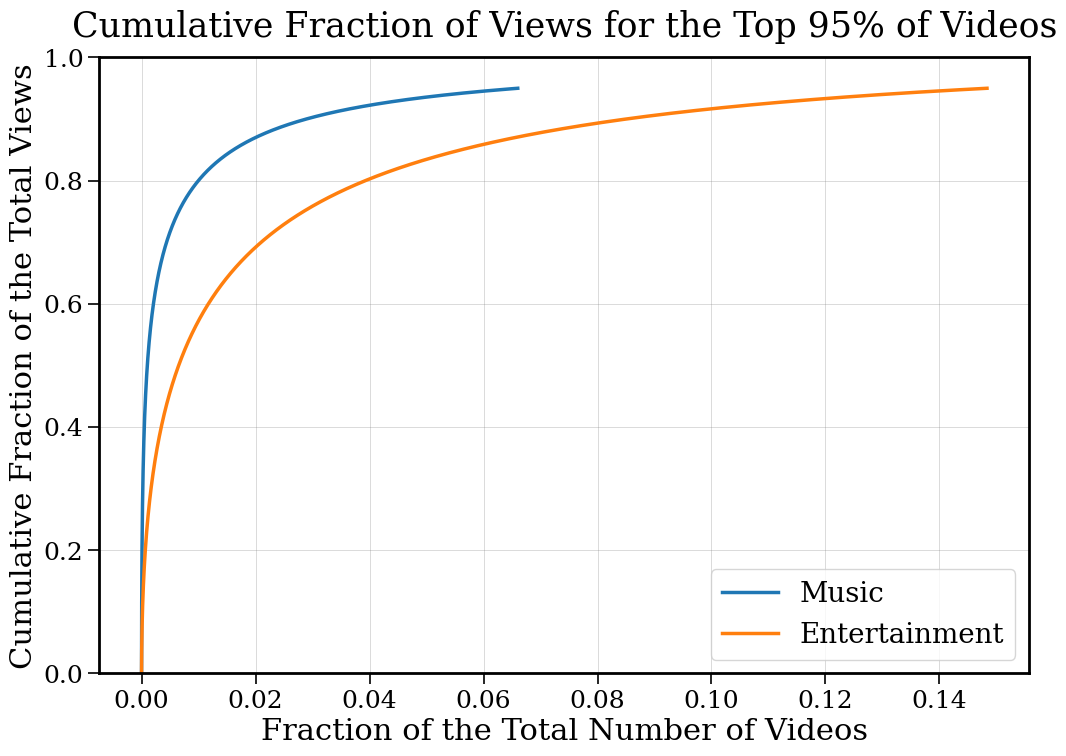

In [ ]:
# Print and plot the result of the filtering step
collab_utils.top_p_results(df_views_music, df_top_p_music, df_views_entertainment, df_top_p_entertainment, p, plot=True)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comments on the results:** 

The plot illustrates the cumulative fraction of views for the top 95% of videos in the Music and Entertainment categories. It reveals significant differences in view distribution between the two. The $x$-axis represents the fraction of top videos included, while the $y$-axis shows the cumulative proportion of total views. 

- The Music curve rises sharply. This indicates that a small fraction of top music videos (6.60%) captures the majority of total views (95%). 
- The Entertainment curve increases more gradually. It requires more than double the fraction of videos (14.83%) to achieve the same cumulative share of views (95%).

</div>

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

In the following section, the analysis focuses on the dataset composed of the top 95% of videos (as defined above). This choice is motivated by two reasons: one practical, the other methodological. 
- The practical reason is that the filtered dataset is more manageable and allows for faster processing.
- The methodological reason is that this choice makes sense as these videos dominate the platform’s dynamics. They account for the majority of views and represent the most impactful content. 



</div> 

## 3.2. Collaboration Detection: Does Collaboration Have an Overall Beneficial Effect in Terms of Viewership, Number of Likes and Dislikes? 

### Collaboration Detection using Video Titles

In [ ]:
# Load the data
top_p_music = pd.read_json("data/top_95.0_Music.jsonl.gz", lines=True, compression="gzip")

In [ ]:
top_p_entertainment = pd.read_json("data/top_95.0_Entertainment.jsonl.gz", lines=True, compression="gzip")

In [ ]:
# Detect collaborations and sort the data by the number of views
top_p_music["collab"] = top_p_music["title"].apply(lambda x: collab_utils.detect_collaboration(x))
top_p_entertainment["collab"] = top_p_entertainment["title"].apply(lambda x: collab_utils.detect_collaboration(x))

top_p_entertainment = top_p_entertainment.sort_values(by="view_count", ascending=False)
top_p_music = top_p_music.sort_values(by="view_count", ascending=False)

In [ ]:
collab_utils.print_collab_stats(top_p_music, top_p_entertainment)

Category                       Number of Videos     Number of Collaborations       Fraction            
-------------------------------------------------------------------------------------------------------
Music                          541108               67893                          12.55%              
Entertainment                  1782414              46357                          2.60%               


### Comparison of the distribution of Views, Likes and Dislikes across Collaborations and Non-collaborations

#### Music Category

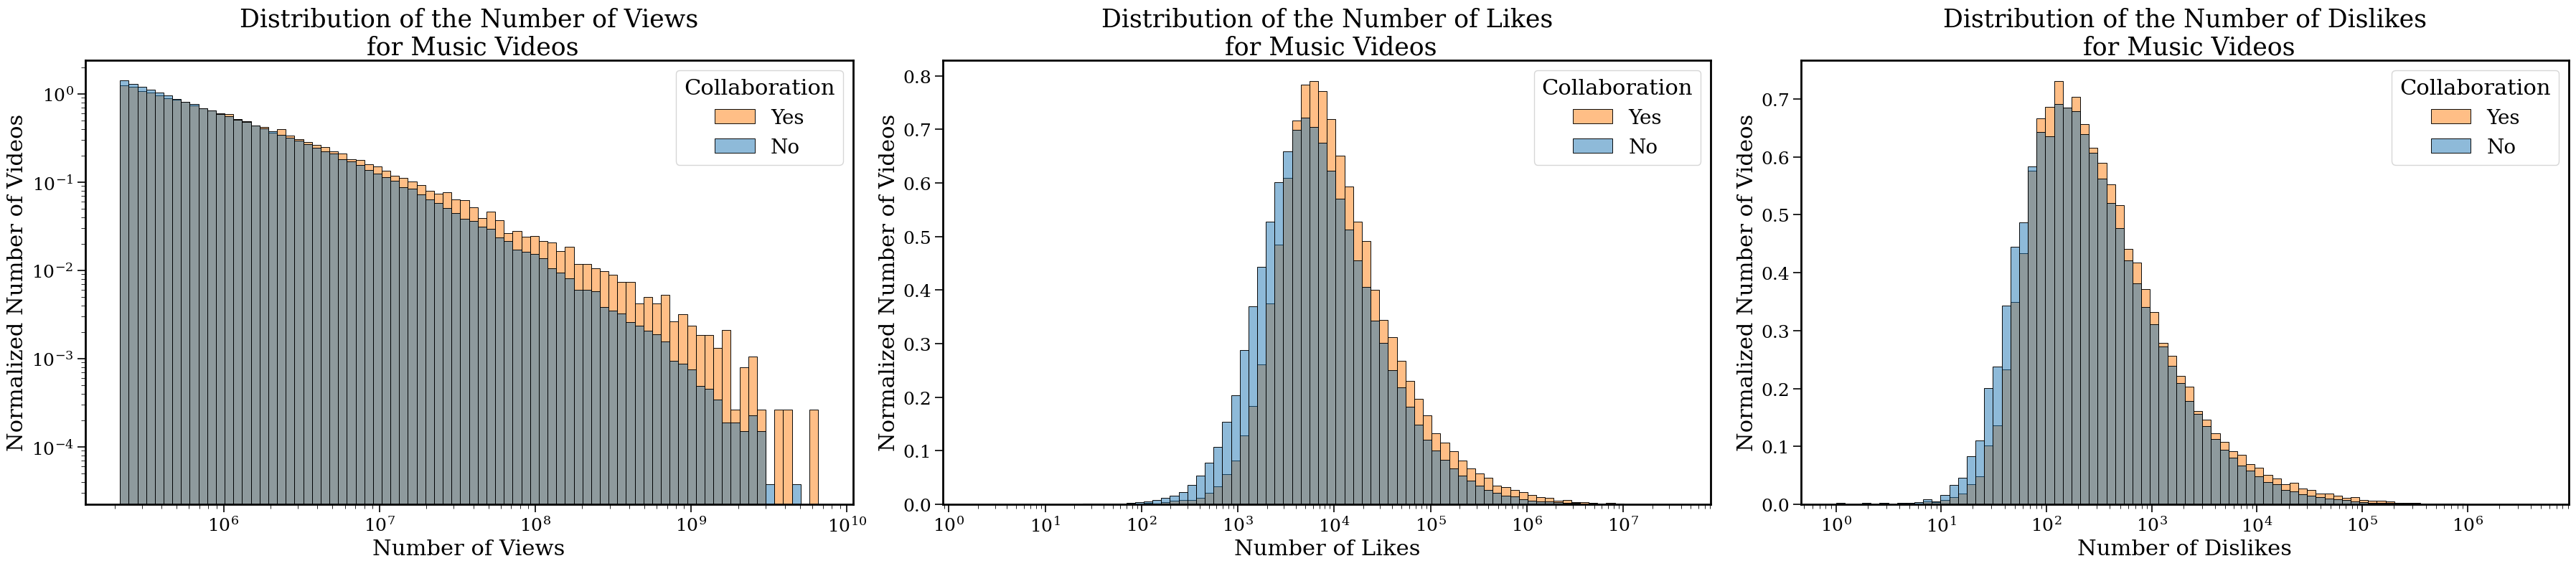

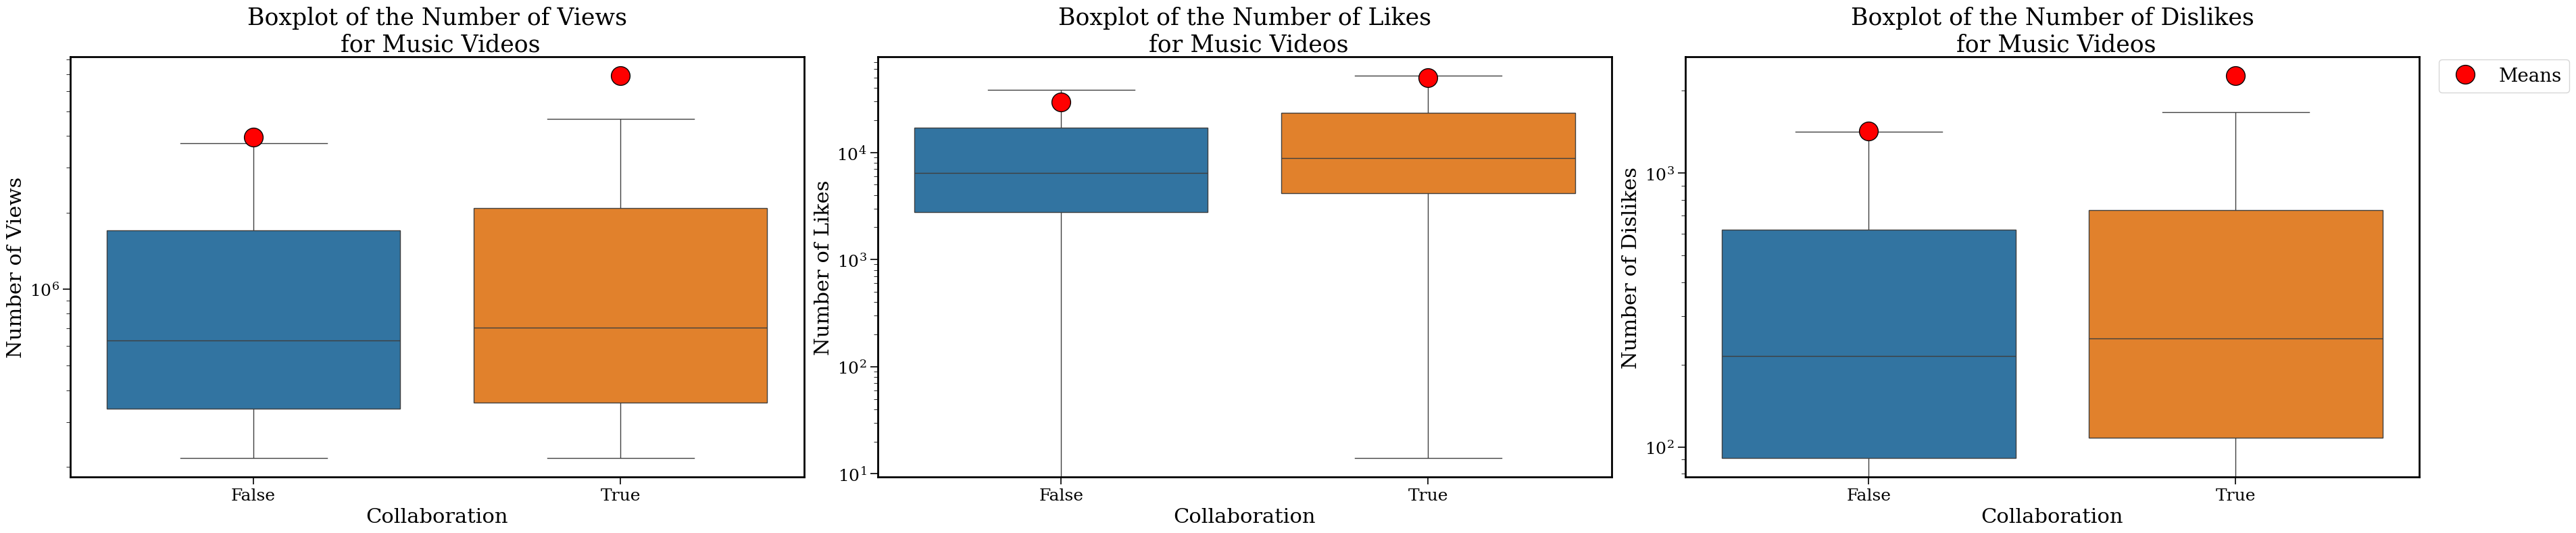

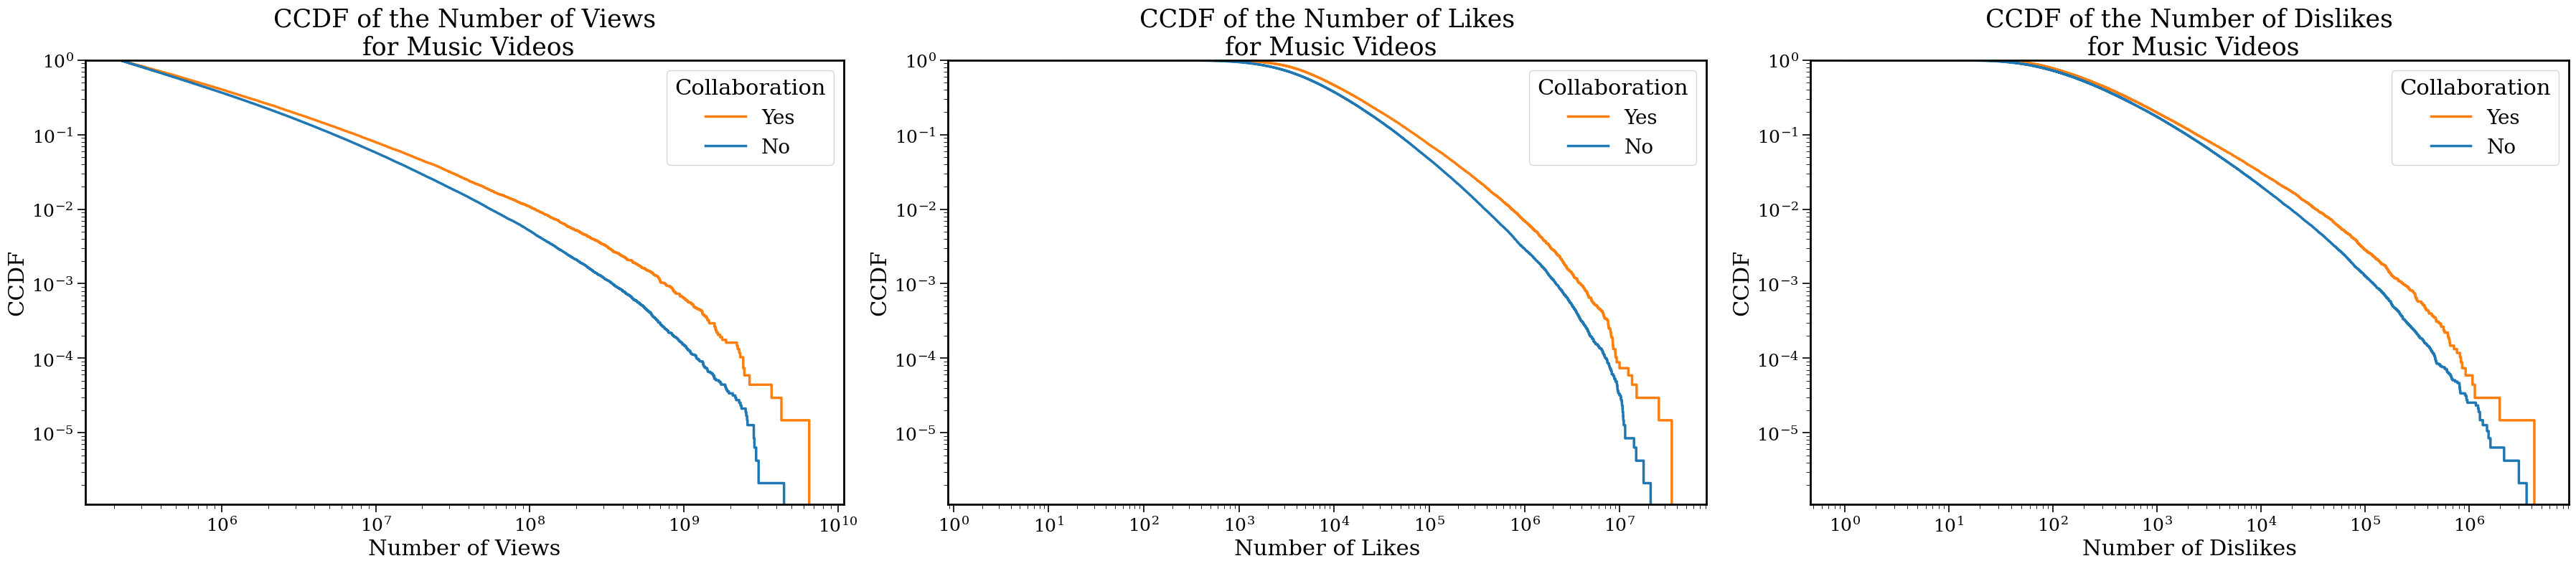

In [ ]:
# Compare the different distributions between collaborations and non collaborations for the Music category
columns = ["view_count", "like_count", "dislike_count"]
custom_labels = {"view_count": "Number of Views", "like_count": "Number of Likes",
                 "dislike_count": "Number of Dislikes"}
x_logs = [True, True, True]
y_logs = [True, False, False]

collab_utils.plot_comparison_collab_and_non_collab(
    data=top_p_music,
    category="Music",
    columns=columns,
    x_logs=x_logs,
    y_logs=y_logs,
    custom_labels=custom_labels,
    save=True,
)

In [ ]:
collab_utils.compare_means_collab_non_collab(top_p_music, columns, custom_labels)

╒═════════════════════════╤══════════════════╤══════════════════════╤════════════════╕
│ Metric                  │ Collaborations   │ Non-Collaborations   │   Ratio (C/NC) │
╞═════════════════════════╪══════════════════╪══════════════════════╪════════════════╡
│ Mean Number of Views    │ 6,901,665.40     │ 3,963,053.55         │           1.74 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Likes    │ 49,664.34        │ 29,515.81            │           1.68 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Dislikes │ 2,271.68         │ 1,423.92             │           1.6  │
╘═════════════════════════╧══════════════════╧══════════════════════╧════════════════╛


In [ ]:
collab_utils.test_distributions(top_p_music, columns, custom_labels)

╒═════════════════════════════════════════╤═════════════╤═══════════╤════════════════╕
│ Test                                    │   Statistic │   P-Value │ Significant?   │
╞═════════════════════════════════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (Number of Views)        │    1.7e+10  │ 1.06e-122 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Views)    │    0.0388   │ 5.36e-78  │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (Number of Views)      │   52.72     │ 0         │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (Number of Likes)        │    1.86e+10 │ 0         │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Likes)    │

#### Entertainment Category

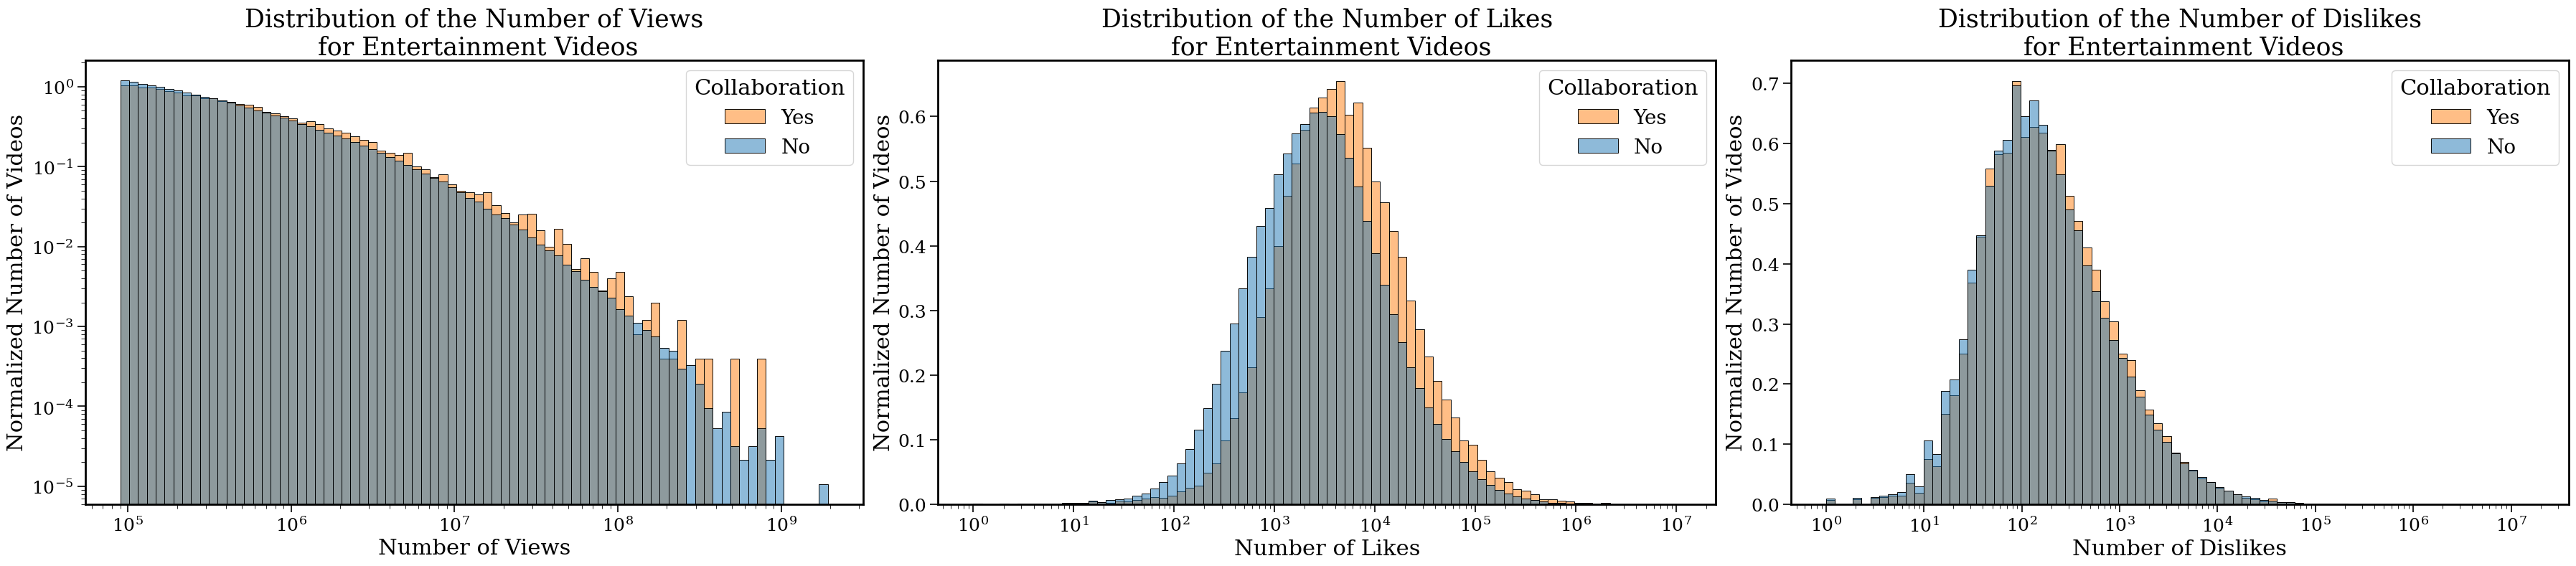

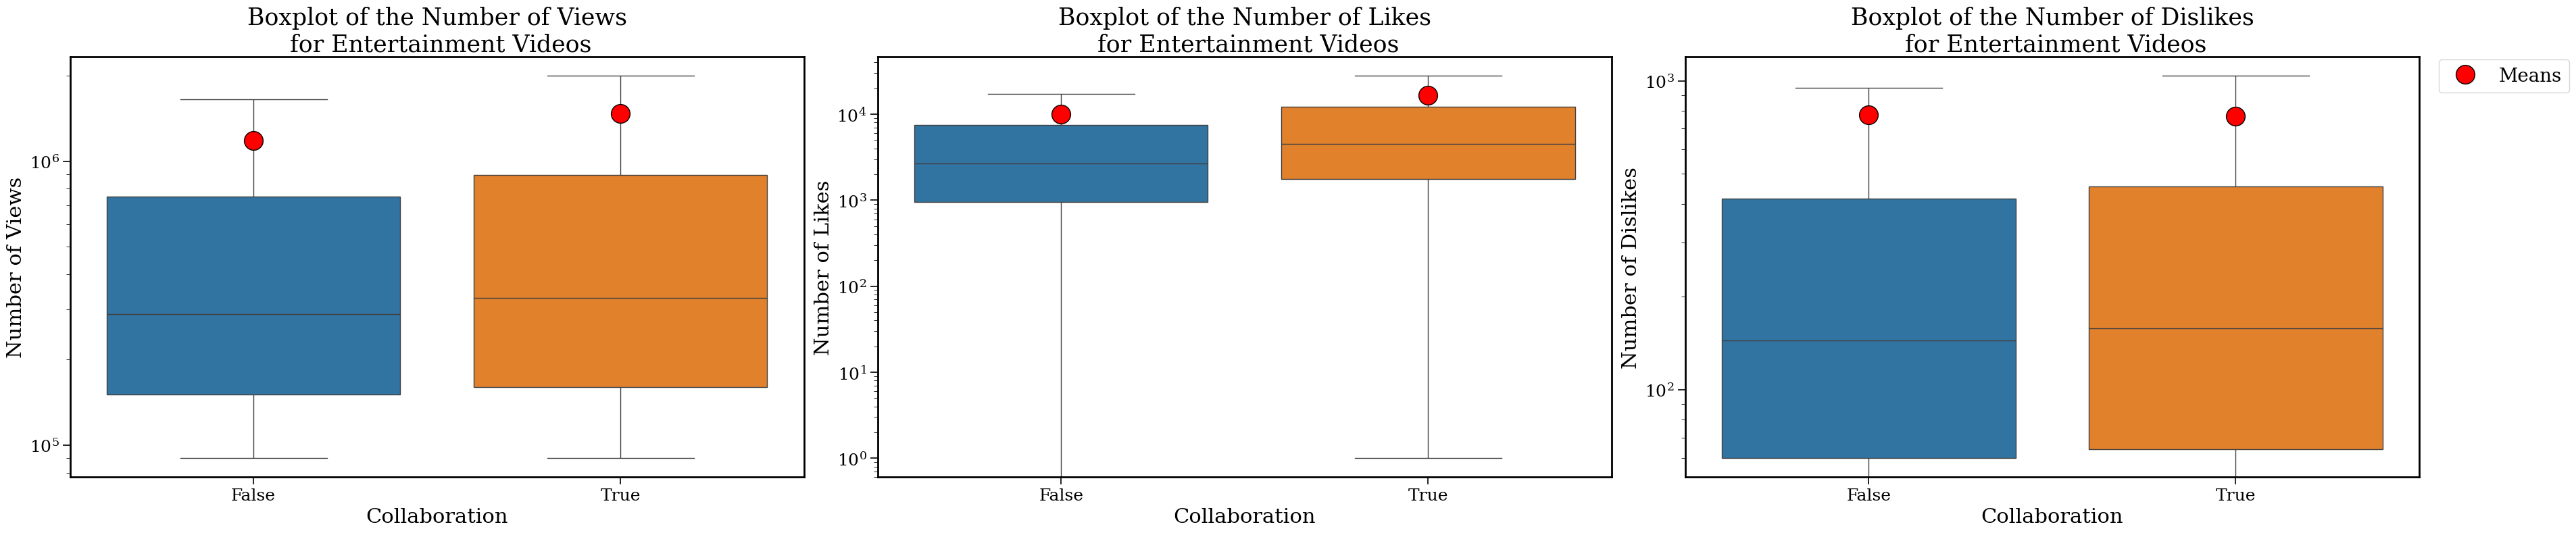

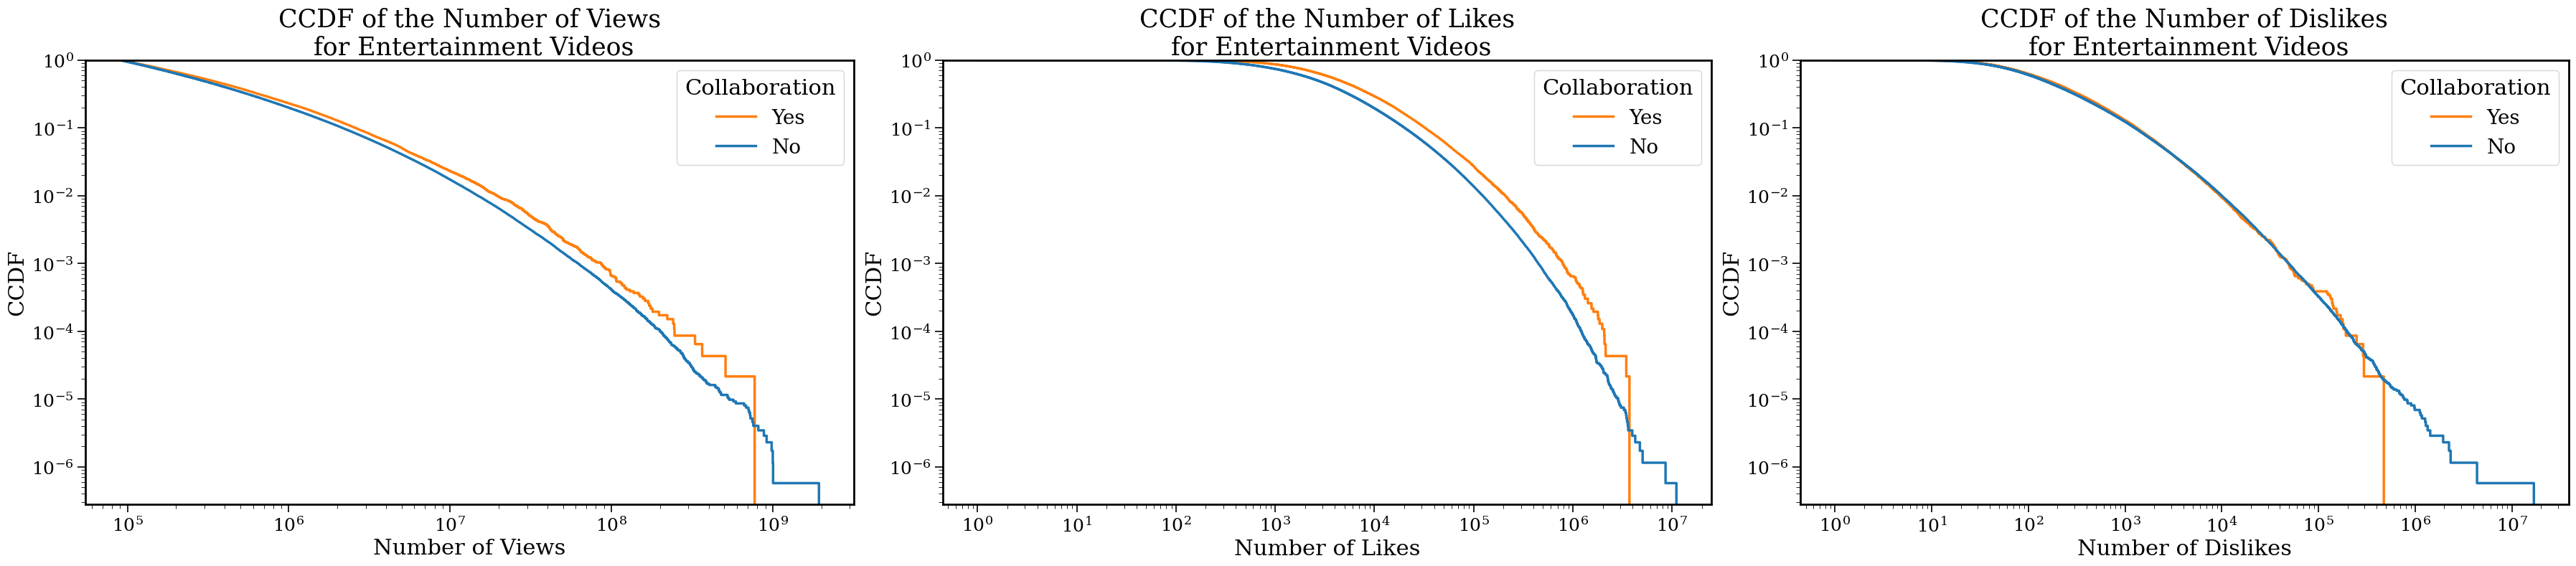

In [ ]:
# Compare the different distributions between collaborations and non collaborations for the Entertainment category
collab_utils.plot_comparison_collab_and_non_collab(
    data=top_p_entertainment,
    category="Entertainment",
    columns=columns,
    x_logs=x_logs,
    y_logs=y_logs,
    custom_labels=custom_labels,
    save=True,
)

In [ ]:
collab_utils.compare_means_collab_non_collab(top_p_entertainment, columns, custom_labels)

╒═════════════════════════╤══════════════════╤══════════════════════╤════════════════╕
│ Metric                  │ Collaborations   │ Non-Collaborations   │   Ratio (C/NC) │
╞═════════════════════════╪══════════════════╪══════════════════════╪════════════════╡
│ Mean Number of Views    │ 1,471,830.73     │ 1,181,247.34         │           1.25 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Likes    │ 16,580.74        │ 10,034.68            │           1.65 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Dislikes │ 768.05           │ 774.44               │           0.99 │
╘═════════════════════════╧══════════════════╧══════════════════════╧════════════════╛


In [ ]:
collab_utils.test_distributions(top_p_entertainment, columns, custom_labels)

╒═════════════════════════════════════════╤═════════════╤═══════════╤════════════════╕
│ Test                                    │   Statistic │   P-Value │ Significant?   │
╞═════════════════════════════════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (Number of Views)        │    4.24e+10 │  5.68e-90 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Views)    │    0.0422   │  3.34e-70 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (Number of Views)      │   40.12     │  0        │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (Number of Likes)        │    4.85e+10 │  0        │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Likes)    │

## 3.3 Collaboration-Ratio Based Analysis

In [ ]:
collab_utils.test_distribution_top_vs_bottom(top_data=[top_p_music_channels, top_p_entertainment_channels], 
                                             bottom_data=[bottom_p_music_channels, bottom_p_entertainment_channels],
                                             categories=["Music", "Entertainment"],
                                             columns=["collab_ratio"])

╒═══════════════════════════════════╤═══════════════╤═════════════╤═══════════╤════════════════╕
│ Test                              │ Category      │   Statistic │   P-Value │ Significant?   │
╞═══════════════════════════════════╪═══════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (collab_ratio)     │ Music         │    1.15e+07 │  8.48e-16 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (collab_ratio) │ Music         │    0.14     │  1.92e-14 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (collab_ratio)   │ Music         │  725        │  1.68e-07 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (collab_ratio)     │ Entertainment │    1.37e+07 │  0.00342  │ Yes            │
├─────────────────────────────